In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 

%load_ext autoreload  
%autoreload 2
#from orbsubs import *   

#import matplotlib.mlab as mlab  # using griddata from here
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as ndimage
from scipy.interpolate import griddata  # got it to work!
from scipy.interpolate import interp1d
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy.polynomial.polynomial as poly

#from sphere import *
from scipy.special import sph_harm  # spherical harmonics
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.sph_harm.html

# some color maps
#colormap='gist_ncar'
#colormap='gist_stern'
#colormap='terrain'
#colormap='prism'
#colormap='rainbow'
#https://matplotlib.org/examples/color/colormaps_reference.html


this routine makes the following figures for the bennu paper
 grad_eq_long.png 
 grad_15_long.png 
 grad_65_long.png 
 grad_eq_short.png 
 grad_15_short.png 
 grad_65_short.png 
 grad_eq_ch.png 
 grad_15_ch.png 
 grad_65_ch.png 
 bennu_elelvation.png


In [2]:
angfac = 180.0/np.pi # for converting radians to degrees
twopi = np.pi*2.0

# return filename
def getfilename(fileroot,npi):  # file format fileroot_%d.txt
    junk = '.txt'
    zeros = ''
    if (npi<10):
        zeros = zeros+ '0'
    if (npi<100):
        zeros = zeros+ '0'
    if (npi<1000):
        zeros = zeros+ '0'
    if (npi<10000):
        zeros = zeros+ '0'
    filename = "%s_%s%d%s"%(fileroot,zeros,npi,junk)
    return filename

# read in a surface file format fileroot_%d.txt
# A surface file only contains nodes near the surface
# if npi==-1 then readin the special file fileroot_nosprings.txt instead
def readsurffile(fileroot,npi):
    if (npi<0):
        filename = fileroot + "_nosprings.txt"  
        # this file should have gravity only in ax,ay,az
    else:
        filename=getfilename(fileroot,npi)
    #print(filename)
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm =\
           np.loadtxt(filename, skiprows=1, unpack='true')
    rad = np.sqrt(x*x + y*y + z*z)
    latarr = np.arcsin(z/rad)  # range [-pi/2,pi/2]
    lonarr_neg = np.arctan2(y,x)   # range [-pi,pi]
    lonarr = (lonarr_neg + twopi)%twopi
    vr = (vx*x + vy*y + vz*z)/rad  # radial component of velocity
    ar = (ax*x + ay*y + az*z)/rad  # radial component of acceleration
    return tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar


In [3]:
# read in shape vertices of bennu shape model
def readbennushape():
    filename = '../bennu2/101955bennu.tab'
    x,y,z = np.genfromtxt(filename,  unpack='true', usecols = (1, 2, 3)) # floats
    s = np.genfromtxt(filename,usecols=(0),dtype='S1')  #strings!
    kk = np.where(s == b'v')  # use vertices only!
    #correct from km to mean radius.   mean radius 246m is  0.246km
    fac = 0.246
    xv=x[kk]/fac  
    yv=y[kk]/fac
    zv=z[kk]/fac
    return xv,yv,zv  # return positions of vertices 

# to test
#xv,yv,zv=readbennushape()
#plt.plot(xv,yv,'.')

In [4]:
# all grids the same
gridn=50  # for grids 
maxlon=2.5*np.pi  # for griding!
lonfac = 1.8   # all grids should be the same!
# lats_i, lons_i are meshgrids
def forgrid():
    lats = np.linspace(-np.pi/2, np.pi/2, gridn) # latitude grid
    lons = np.linspace(0.0, maxlon, lonfac*gridn)  #longitude grid
    lons_i, lats_i = np.meshgrid(lons, lats)  # rectangular grid
    return lats,lons,lats_i,lons_i

# do interpolation,  lonarr,latarr,show_arr are the points
# grid is given by lons_i,lats_i (mesh grids arrays)
# ohow works for lon > 2pi 
def gridit_interp(lonarr,latarr,show_arr,lons_i,lats_i):
    latarr2 = np.append(latarr,latarr)
    lonarr2 = np.append(lonarr,lonarr+2.0*np.pi)
    show_arr2 = np.append(show_arr,show_arr)
    zi = griddata((lonarr2,latarr2),show_arr2,(lons_i,lats_i), method='linear')
    zin = griddata((lonarr2,latarr2),show_arr2,(lons_i,lats_i), method='nearest')
    # interpolate the data. doing it twice so can cover more than 2pi in longitude
    kk = np.where(np.isnan(zi))
    zi[kk] = zin[kk]  
    return zi
# interpolation does not smooth or average over noisy data, I think only takes nearest
# so is very noisy, however we don't have enough points to do better than this!

# trying to average where there are many points
# I tried this and found that we are not actually oversampled much
# interpolation is in fact the correct method for us right now!
# don't use this!
def gridit_average(lonarr,latarr,show_arr,lons,lats,lons_i,lats_i):
    zi = gridit_interp(lonarr,latarr,show_arr,lons_i,lats_i)
    zave = zi*0.0
    nlo = len(lons_i)
    nla = len(lats_i)
    for i in range(nlo-1): #longitudes
        lonmin = lons[i]
        lonmax = lons[i+1]
        for j in range(nla-1):
            latmin = lats[j]
            latmax = lats[j+1]
            good = (lonarr>lonmin)&(lonarr<lonmax)&(latarr>latmin)&(latarr<latmax)
            good2 = ((lonarr+2*np.pi>lonmin)&(lonarr+2*np.pi<lonmax)&(latarr>latmin)&(latarr<latmax))
            kk = np.where(good|good2)
            val = np.mean(show_arr[kk])
            zave[j,i] = val
    return zave

In [18]:
# compute magnitude of effective surface gravitational acceleration (including centripetal)
# returns arrays (of each surface particle)
# returns the acceleration magnitude and direction unit vector
def ageomag(fileroot):
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,-1)
    # this file should have gravity only in ax,ay,az
    epsilon = 0.00001
    rad_project = np.sqrt(x*x+y*y + epsilon) # neglecting z
    vphi = (-vx*y + vy*x)/rad_project
    omega = np.median(vphi/rad_project)  # is a number that agrees with what it ought to be
    omega2 = omega*omega  # square of spin rate
    a_rot_x = omega2*x  # positive r,  ar was negative
    a_rot_y = omega2*y
    a_geo_x = a_rot_x + ax
    a_geo_y = a_rot_y + ay
    a_geo_z = az
    a_geo_mag = np.sqrt(a_geo_x**2 + a_geo_y**2 + a_geo_z**2) # I did check signs!
    a_hat_x = a_geo_x/a_geo_mag
    a_hat_y = a_geo_y/a_geo_mag
    a_hat_z = a_geo_z/a_geo_mag 
    ahat_vec = (a_hat_x,a_hat_y,a_hat_z)  # a tuple of arrays!
    return a_geo_mag, ahat_vec

# return <vr^2> computed within range npi, npj, as an array for all surf particles
# returns array (each surface particle) and latarr,lonarr
# a new parameter decayrate lets you decay things if you want to
def avevr2(fileroot,npi,npj,decayrate):
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,npi)
    vr2sum = 0*vr
    t0 = tt[0]
    for i in range(npi,npj):
        # read in surface mass nodes from file
        tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,i)
        tfac = np.exp(-(tt[0]-t0)*decayrate)
        vr2sum = vr2sum + vr*vr*tfac
    vr2sum = vr2sum/float(npj-npi)
    #print('time of last file ', tt[0])
    return latarr,lonarr,vr2sum  #might be noisy?

# return maximum positive vr computed within range npi, npj, as an array for all surf particles
# returns array (each surface particle) and latarr,lonarr
# a new parameter decayrate lets you decay things if you want to
def maxvrpos(fileroot,npi,npj,decayrate):
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,npi)
    mysum = 0*vr
    t0 = tt[0]
    for i in range(npi,npj):
        # read in surface mass nodes from file
        tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,i)
        tfac = np.exp(-(tt[0]-t0)*decayrate)
        kk = np.where(vr*tfac > mysum)
        mysum[kk] = vr[kk]
    #print('time of last file ', tt[0])
    return latarr,lonarr,mysum  


# polynomial fit to azimuthally averaged surface r_xy(z)
# returns:
#   polyfitfun is r_xy(z)
#   polyfitfunder is drdz(z)
poly_n = 10  # index of polynomial
def surfnormal_funs(fileroot):
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,-1)
    rad = np.sqrt(x*x + y*y + z*z)
    rad2 = np.sqrt(x*x + y*y)
    poly_coefs = poly.polyfit(z, rad2, poly_n)  # fit a polynomial 
    polyfitfun = poly.Polynomial(poly_coefs)  # return the fitted function
    poly_coefs_der = poly.polyder(poly_coefs) # a new set of poly coeffs, derivative
    polyfitfunder = poly.Polynomial(poly_coefs_der)  # function for dr/dz
    return polyfitfun,polyfitfunder
      
# return a surface normal in cartesian coordinates
# drdzfun is the function drdz(z) from a polyfit to azimuthally averaged surface
# works on vectors
def nhat(drdzfun,x,y,z):
    drdz = drdzfun(z)
    alpha = np.arctan2(drdz,1.0)
    nhat_z = -np.sin(alpha); 
    nhat_rxy = np.cos(alpha)
    phi = np.arctan2(y,x)
    nhat_x = nhat_rxy*np.cos(phi)
    nhat_y = nhat_rxy*np.sin(phi)
    return nhat_x,nhat_y,nhat_z  # returns a unit vector normal to surface (az averaged)

# return surface normal at position of every surface node
def surfnormal(fileroot):
    polyfitfun,drdzfun= surfnormal_funs(fileroot)
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,-1)
    nhat_x,nhat_y,nhat_z = nhat(drdzfun,x,y,z)
    return nhat_x,nhat_y,nhat_z


# to test fit of surface azimuthally average, just plot it
def plt_surfnorm(fileroot):
    polyfitfun,polyfitfunder= surfnormal_funs(fileroot)
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,-1)
    rad2 = np.sqrt(x*x+y*y)

    zlin = np.linspace(-1.2,1.2,30)
    zfit = polyfitfun(zlin)
    drdz = polyfitfunder(zlin)
    
    plt.figure()
    ax = plt.gca()
    ax.set_aspect('equal')

    plt.plot(z,rad2,'.',ms=1)
    plt.plot(zlin, zfit,'-')
    plt.xlabel('z')
    plt.ylabel('rxy')
    plt.xlim(-1.3,1.3)
    plt.ylim(0,np.max(rad2))

    alpha = np.arctan(drdz)
    shatz = np.sign(-zlin)*np.cos(alpha); shatr = np.sign(-zlin)*np.sin(alpha)
    ax.quiver(zlin, zfit-0.1, shatz, shatr,color='red')  #surface slope
    nhatz = -np.sin(alpha); nhatr = np.cos(alpha)
    ax.quiver(zlin, zfit, nhatz, nhatr,color='black')  #surface normal
    
    
# using surface normal and ageo give us the angle of the surface between
# these two unit vectors
# this is beta in paper
# returns an angle for all points
def surfaceslope(fileroot):
    nhat_x,nhat_y,nhat_z = surfnormal(fileroot)
    a_geo_mag, ahat_vec = ageomag(fileroot)
    ahat_x = ahat_vec[0]
    ahat_y = ahat_vec[1]
    ahat_z = ahat_vec[2]
    dotproduct = -1.0*(nhat_x*ahat_x + nhat_y*ahat_y+ nhat_z*ahat_z)
    angle = np.arccos(dotproduct)
    return angle

def nhat_cone(x,y,z):
    slope=0.8
    sigz=0.05
    phi = np.arctan2(y,x)
    slope_smo = slope*(1.0 - np.exp(-z*z/(2*sigz**2))) # keep equator from being bad
    nhat_x = np.cos(slope_smo)*np.cos(phi)  # surface normal does not depend on much
    nhat_y = np.cos(slope_smo)*np.sin(phi)
    nhat_z = np.sin(slope_smo)*np.sign(z)
    return nhat_x,nhat_y,nhat_z

def nhat_oblate(x,y,z):
    axisratio=0.8
    phi = np.arctan2(y,x)
    rad2 = np.sqrt(x*x+y*y)
    alpha = np.arctan2(rad2/axisratio**2,z)
    nhat_x = np.sin(alpha)*np.cos(phi)  
    nhat_y = np.sin(alpha)*np.sin(phi)
    nhat_z = np.cos(alpha)
    return nhat_x,nhat_y,nhat_z

# using surface normal and ageo give us the angle of the surface between
# these two unit vectors
# this is beta in paper
# returns an angle for all points
# if surface is a cone or oblate then compute the surface normal directly
# instead of fitting to points
def surfaceslope_shape(fileroot,shape):
    a_geo_mag, ahat_vec = ageomag(fileroot)
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,-1)
    rad2 = np.sqrt(x*x+y*y)
    nhat_x = 0
    nhat_y = 0
    nhat_z = 0
    if (shape =='c'):  #cone model
        nhat_x,nhat_y,nhat_z =nhat_cone(x,y,z) 
    if (shape =='o'):  #oblate model
        nhat_x,nhat_y,nhat_z =nhat_oblate(x,y,z) 
    else:  # use points to make shape model and find surface normal from that
        nhat_x,nhat_y,nhat_z = surfnormal(fileroot)
     
    ahat_x = ahat_vec[0]
    ahat_y = ahat_vec[1]
    ahat_z = ahat_vec[2]
    dotproduct = -1.0*(nhat_x*ahat_x + nhat_y*ahat_y+ nhat_z*ahat_z)
    angle = np.arccos(dotproduct)
    return angle   
        
        

In [6]:
# polynomial fit to azimuthally averaged surface r(lambda)
# also assuming z, -z symetry otherwise poly fit sucks
# returns:
#   polyfitfun is r(lambda)
#   polyfitfunder is drdlambda(lambda) only call this with abs of lambda
poly_n = 10  # index of polynomial
def lambda_funs(fileroot):
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,-1)
    rad = np.sqrt(x*x + y*y + z*z)
    poly_coefs = poly.polyfit(np.abs(latarr), rad, poly_n)  # fit a polynomial 
    polyfitfun = poly.Polynomial(poly_coefs)  # return the fitted function
    poly_coefs_der = poly.polyder(poly_coefs) # a new set of poly coeffs, derivative
    polyfitfunder = poly.Polynomial(poly_coefs_der)  # function for dr/dz
    return polyfitfun,polyfitfunder  # return functions

# to test fit of surface azimuthally average, just plot it
def plt_lambda_funs(fileroot):
    polyfitfun,polyfitfunder= lambda_funs(fileroot)
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,-1)
    rad = np.sqrt(x*x+y*y + z*z)

    lamlin = np.linspace(-np.pi/2,np.pi/2,30)
    lamfit = polyfitfun(np.abs(lamlin))
    drdlam = polyfitfunder(lamlin)
    
    plt.figure()
    ax = plt.gca()
    #ax.set_aspect('equal')

    plt.plot(latarr,rad,'.',ms=1)
    plt.plot(lamlin, lamfit,'-')
    plt.xlabel('lambda')
    plt.ylabel('r')
    plt.xlim(-np.pi/2,np.pi/2)
    plt.ylim(np.min(rad),np.max(rad))

# compute the factor we need to fix the gradient along surface toward equator
# compute (drd/lamdba**2 + r*2)^-1/2
def grads_sfac(fileroot):
    polyfitfun,drdlam_fun = lambda_funs(fileroot)
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,-1)
    rad = np.sqrt(x*x+y*y + z*z)
    drdl = drdlam_fun(np.abs(latarr))
    fac = 1.0/np.sqrt(drdl**2 + rad**2)
    return fac
    
    
      

In [68]:
# just to look at stuff on grids! not yet grided
def plt_on_grid(lonarr,latarr,show_arr,zmin,zmax):
    lats,lons,lats_i,lons_i = forgrid()
    zi=gridit_interp(lonarr,latarr,show_arr,lons_i,lats_i) 
    matplotlib.rc('xtick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14) 
    fig=plt.figure(figsize=(8,4))
    plt.pcolormesh(lons_i,lats_i,zi,vmin=zmin, vmax=zmax, cmap='gist_ncar')
    plt.colorbar()
    plt.axis([0, maxlon, -np.pi/2, np.pi/2])
    
    ylabels = [r'$-\pi/2$','0',r'$\pi/2$']
    plt.yticks([-np.pi/2,0,np.pi/2],ylabels)
    xlabels = [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$', r'0', r'$\pi/2$']
    plt.xticks([0.0,np.pi/2,np.pi,3*np.pi/2,2*np.pi, 2.5*np.pi],xlabels)
    
# just to look at stuff on grids! already grided
def plt_grided(zi,zmin,zmax):   
    lats,lons,lats_i,lons_i = forgrid()
    matplotlib.rc('xtick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14) 
    fig,ax = plt.subplots(1,1, dpi=300, figsize=(8,4), sharex=True,sharey=True)
    plt.subplots_adjust(left=0.16, right=0.9, top=0.95, bottom=0.16, \
        wspace=0.22, hspace=0.0)
    #fig=plt.figure(figsize=(8,4))
    im = ax.pcolormesh(lons_i,lats_i,zi,vmin=zmin, vmax=zmax, cmap='gist_ncar')
    #ax.colorbar()
    plt.axis([0, maxlon, -np.pi/2, np.pi/2])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ylabels = [r'$-\pi/2$',r'$-\pi/4$',r'0',r'$\pi/4$']
    ax.set_yticks([-np.pi/2,-np.pi/4,0,np.pi/4])
    ax.set_yticklabels(ylabels)
    xlabels = [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$', r'0', r'$\pi/2$']
    ax.set_xticks([0.0,np.pi/2,np.pi,3*np.pi/2,2*np.pi,2.5*np.pi])
    ax.set_xticklabels(xlabels)
    return fig,ax
    

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


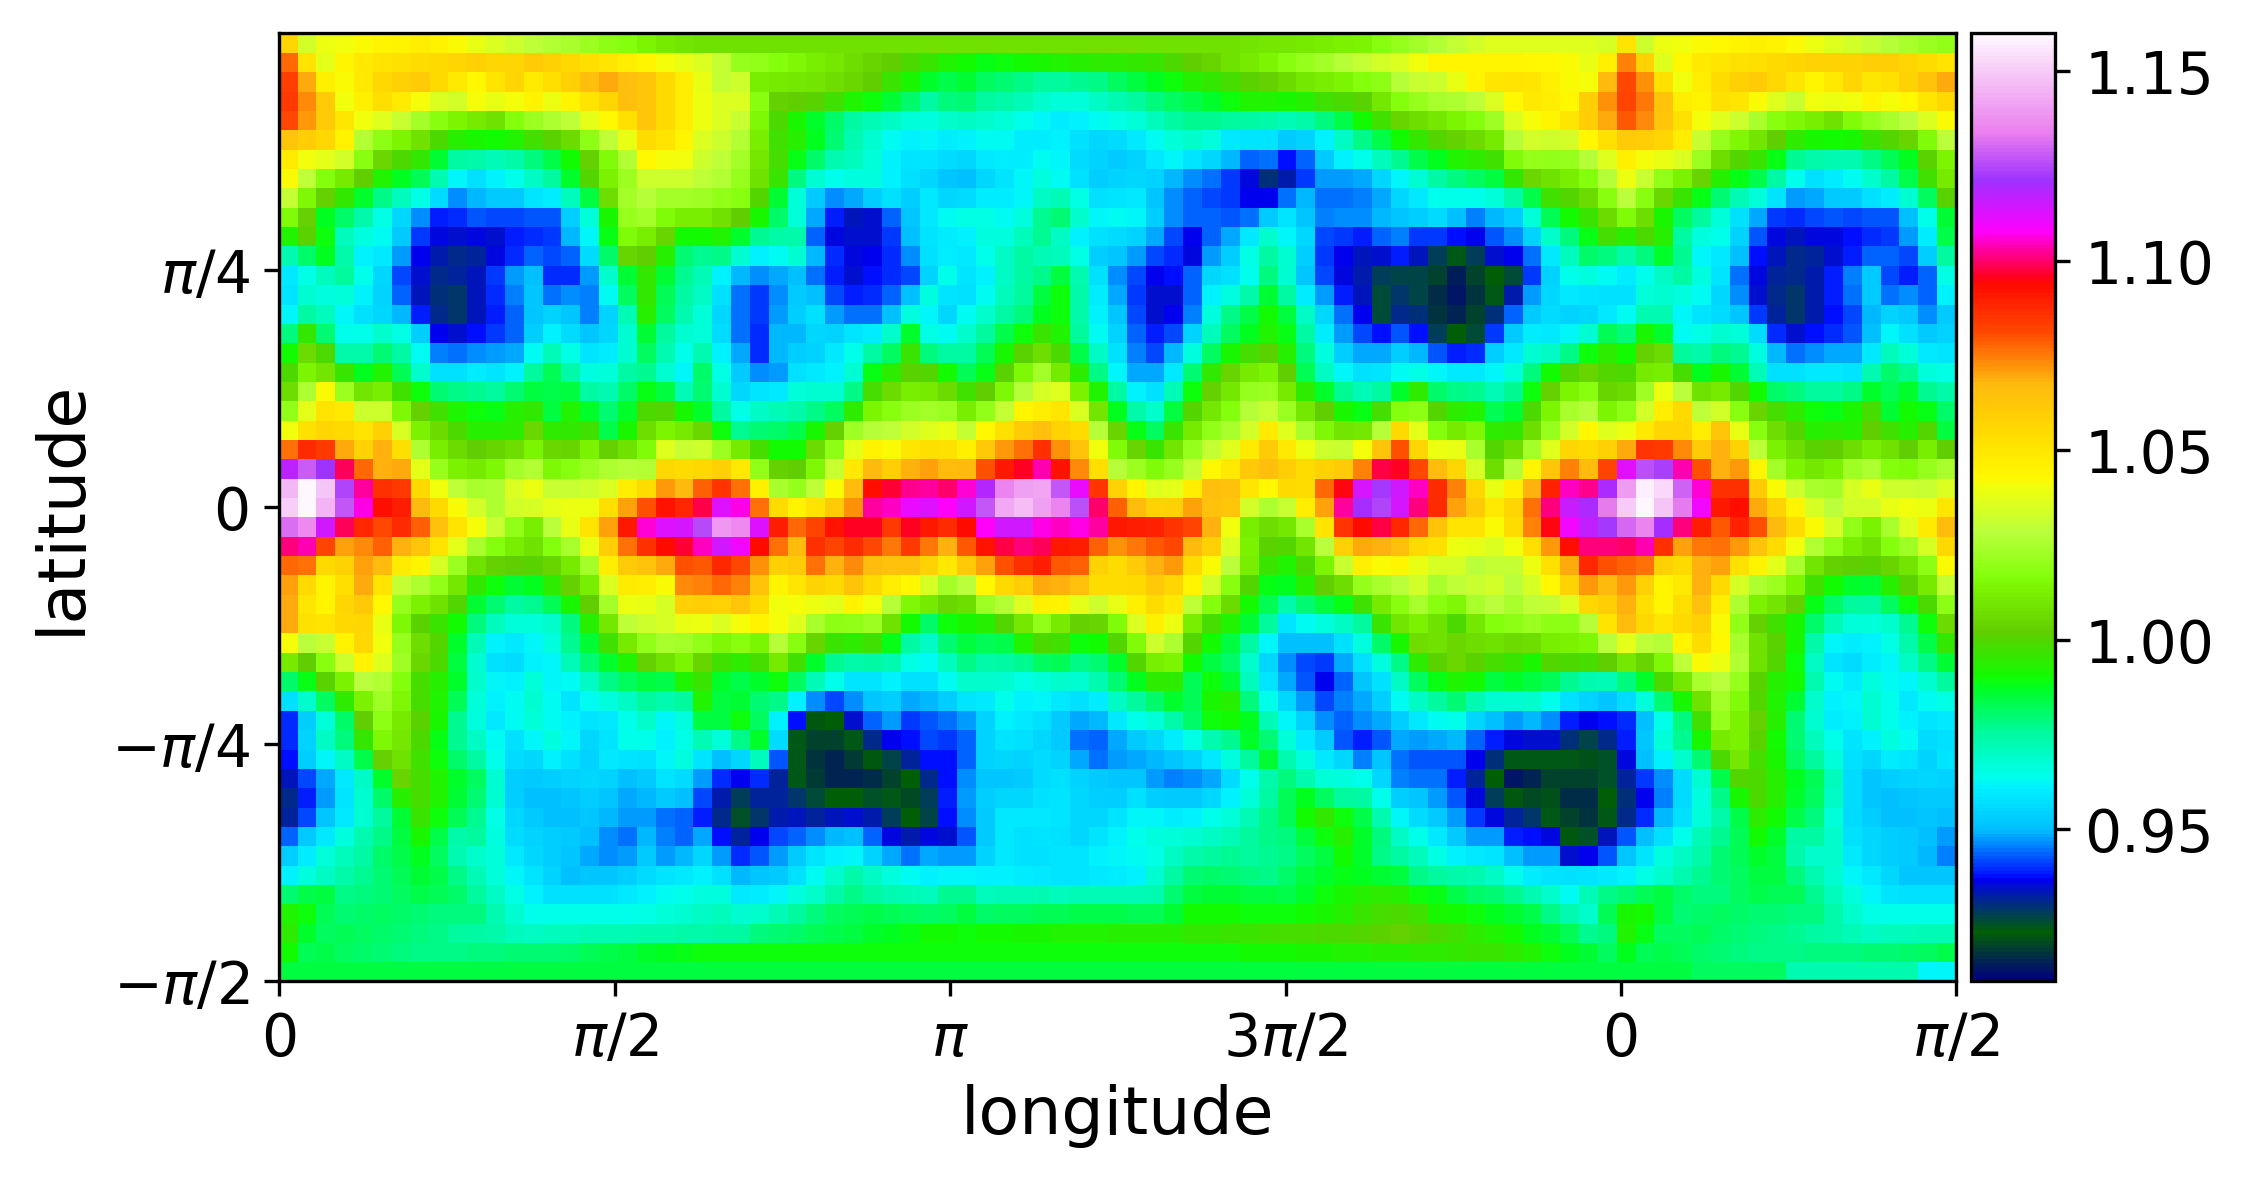

In [69]:
# make an elevation map from the bennu shape model
xv,yv,zv = readbennushape()
rv = np.sqrt(xv**2+yv**2+zv**2)
lats,lons,lats_i,lons_i
latarr = np.arcsin(zv/rv)  # range [-pi/2,pi/2]
lonarr_neg = np.arctan2(yv,xv)   # range [-pi,pi]
lonarr = (lonarr_neg + twopi)%twopi
g_rad=gridit_interp(lonarr,latarr,rv,lons_i,lats_i)
fig,ax=plt_grided(g_rad,0.91,1.16)
ax.set_xlabel("longitude",fontsize=16)
ax.set_ylabel("latitude",fontsize=16)
fig.savefig("bennu_elevation.png",dpi=500)

In [32]:
# not yet grided
# plot 3 sets of gridded data, make grids, only pass pts
def plt3_on_grid(lonarr0,latarr0,show_arr0,
                 lonarr1,latarr1,show_arr1,
                 lonarr2,latarr2,show_arr2,
                 label_arr,zmin,zmax,nsmo,toplabel,ofilename):
    colormap='cubehelix'
    lats,lons,lats_i,lons_i = forgrid()
    zi0=gridit_interp(lonarr0,latarr0,show_arr0,lons_i,lats_i)
    zi1=gridit_interp(lonarr1,latarr1,show_arr1,lons_i,lats_i) 
    zi2=gridit_interp(lonarr2,latarr2,show_arr2,lons_i,lats_i) 
    zi0_smo = ndimage.gaussian_filter(zi0, sigma=(nsmo, nsmo), order=0)
    zi1_smo = ndimage.gaussian_filter(zi1, sigma=(nsmo, nsmo), order=0)
    zi2_smo = ndimage.gaussian_filter(zi2, sigma=(nsmo, nsmo), order=0)
    
    matplotlib.rc('xtick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14) 
   
    f,axarr =  plt.subplots(3,1, dpi=300, figsize=(6,8), sharex=True,sharey=True)
    plt.subplots_adjust(left=0.16, right=0.79, top=0.95, bottom=0.11, \
        wspace=0.22, hspace=0.0)
    
    ip = 0
    axarr[ip].axis([0, maxlon, -np.pi/2, np.pi/2])
    ylabels = [r'$-\pi/2$',r'$-\pi/4$',r'0',r'$\pi/4$']
    axarr[ip].set_yticks([-np.pi/2,-np.pi/4,0,np.pi/4])
    axarr[ip].set_yticklabels(ylabels)
    xlabels = [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$', r'0', r'$\pi/2$']
    axarr[ip].set_xticks([0.0,np.pi/2,np.pi,3*np.pi/2,2*np.pi,2.5*np.pi])
    axarr[ip].set_xticklabels(xlabels)
    
    axarr[ip].text(np.pi/4,np.pi/2+0.08,toplabel,fontsize=18,color='black')  #toplabel
    xlab = 0.2; ylab=np.pi/2-0.4
    ip=0
    im0 = axarr[ip].pcolormesh(lons_i,lats_i,zi0_smo,vmin=zmin, vmax=zmax, cmap=colormap)
    axarr[ip].text(xlab,ylab,label_arr[ip],fontsize=15,color='white')
    ip = 1
    im1 = axarr[ip].pcolormesh(lons_i,lats_i,zi1_smo,vmin=zmin, vmax=zmax, cmap=colormap)
    axarr[ip].text(xlab,ylab,label_arr[ip],fontsize=15,color='white')
    ip = 2
    im2 = axarr[ip].pcolormesh(lons_i,lats_i,zi2_smo,vmin=zmin, vmax=zmax, cmap=colormap)
    axarr[ip].text(xlab,ylab,label_arr[ip],fontsize=15,color='white')
       
    cbaxes0 = f.add_axes([0.81, 0.55, 0.03, 0.35]) 
    cb0= f.colorbar(im0,cax = cbaxes0,format='%.1e')
    cb0.ax.tick_params(labelsize=14)
    
    if (len(ofilename)>3):
        plt.savefig(ofilename)
        
        
# plot 3 sets of gridded data, 
def plt3_grided(zi0,zi1,zi2, 
                label_arr,zmin,zmax,toplabel,ofilename):
    colormap='cubehelix'
    lats,lons,lats_i,lons_i = forgrid()
    matplotlib.rc('xtick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14) 
    
    f,axarr =  plt.subplots(3,1, dpi=300, figsize=(6,8), sharex=True,sharey=True)
    plt.subplots_adjust(left=0.16, right=0.79, top=0.95, bottom=0.11, \
        wspace=0.22, hspace=0.0)
    
    ip = 0
    axarr[ip].axis([0, maxlon, -np.pi/2, np.pi/2])
    ylabels = [r'$-\pi/2$',r'$-\pi/4$',r'0',r'$\pi/4$']
    axarr[ip].set_yticks([-np.pi/2,-np.pi/4,0,np.pi/4])
    axarr[ip].set_yticklabels(ylabels)
    xlabels = [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$', r'0', r'$\pi/2$']
    axarr[ip].set_xticks([0.0,np.pi/2,np.pi,3*np.pi/2,2*np.pi,2.5*np.pi])
    axarr[ip].set_xticklabels(xlabels)
    
    axarr[ip].text(np.pi/4,np.pi/2+0.08,toplabel,fontsize=18,color='black')  #toplabel
    xlab = 0.2; ylab=np.pi/2-0.4
    ip=0
    im0 = axarr[ip].pcolormesh(lons_i,lats_i,zi0,vmin=zmin, vmax=zmax, cmap=colormap)
    axarr[ip].text(xlab,ylab,label_arr[ip],fontsize=15,color='white')
    ip = 1
    im1 = axarr[ip].pcolormesh(lons_i,lats_i,zi1,vmin=zmin, vmax=zmax, cmap=colormap)
    axarr[ip].text(xlab,ylab,label_arr[ip],fontsize=15,color='white')
    ip = 2
    im2 = axarr[ip].pcolormesh(lons_i,lats_i,zi2,vmin=zmin, vmax=zmax, cmap=colormap)
    axarr[ip].text(xlab,ylab,label_arr[ip],fontsize=15,color='white')
       
    cbaxes0 = f.add_axes([0.81, 0.55, 0.03, 0.35]) 
    cb0= f.colorbar(im0,cax = cbaxes0,format='%.1e')
    cb0.ax.tick_params(labelsize=14)
    
    if (len(ofilename)>3):
        plt.savefig(ofilename)
    
    

In [19]:
# compute everything we need for dH/dt, put on grids
# smooth and symmetrize  like crazy except avr2
def allfun(fileroot,npi,npj,shape,decayrate):
    lats,lons,lats_i,lons_i = forgrid()
    latarr,lonarr,avev2=avevr2(fileroot,npi,npj,decayrate)
    latarr,lonarr,maxvr=maxvrpos(fileroot,npi,npj,decayrate)
    
    g_avev2=gridit_interp(lonarr,latarr,avev2,lons_i,lats_i)
    g_maxvr=gridit_interp(lonarr,latarr,maxvr,lons_i,lats_i)
    
    beta = surfaceslope_shape(fileroot,shape)
    a_geo_mag, ahat_vec = ageomag(fileroot)
    sfac = grads_sfac(fileroot)
    
    g_b=gridit_interp(lonarr,latarr,beta,lons_i,lats_i) 
    g_g=gridit_interp(lonarr,latarr,a_geo_mag,lons_i,lats_i)
    g_s=gridit_interp(lonarr,latarr,avev2,lons_i,lats_i)
    smo_lat = 3
    smo_lon = 100
    
    junk = 0.5*(g_b + np.flipud(g_b))  # symetrize updown
    g_beta = ndimage.gaussian_filter(junk, sigma=(smo_lat, smo_lon), order=0) #smooth
    junk = 0.5*(g_g + np.flipud(g_g))  
    g_ageo = ndimage.gaussian_filter(junk, sigma=(smo_lat, smo_lon), order=0)
    junk = 0.5*(g_s + np.flipud(g_s))  
    g_sfac = ndimage.gaussian_filter(junk, sigma=(smo_lat, smo_lon), order=0)
    
    return g_avev2,g_beta,g_ageo,g_sfac,g_maxvr

# compute gradient in s direction on surface of grided combo array
def grad_s(g_combo,g_sfac):
    lats,lons,lats_i,lons_i = forgrid()
    gradcombo = np.gradient(g_combo,lats,lons)
    grads = gradcombo[0]  # should multiply by g_sfac
    return grads    #*szi  # is grided!

In [71]:
filerootb1  = "../bennu2/b1_out/b1_surf"
filerootb2  = "../bennu2/b2_out/b2_surf"
filerootb3  = "../bennu2/b3_out/b3_surf"
filerootc1  = "../bennu2/c3_out/c3_surf"
filerootc2  = "../bennu2/c2_out/c2_surf"
filerootc3  = "../bennu2/c6_out/c6_surf"
filerooto1  = "../bennu2/o1_out/o1_surf"
filerooto2  = "../bennu2/o2_out/o2_surf"
filerooto3  = "../bennu2/o3_out/o3_surf"
label_arr = ['Bennu','Cone','Oblate']
toplabel_0 =  r'impact $\lambda_c = 0^\circ$'
toplabel_15 = r'impact $\lambda_c = 15^\circ$'
toplabel_65 = r'impact $\lambda_c = 65^\circ$'
vr_label = r', $\dot H$'
max_label = r', $\Delta H/h$'
ch_label = r', $\dot H/h$'

In [22]:
npi = 0; npj=100  # only out 100 files!
decayrate = 0.0

g_avev2o1,g_betao1,g_ageoo1,g_sfaco1,g_maxvro1 = allfun(filerooto1,npi,npj,'o',decayrate)
g_avev2o2,g_betao2,g_ageoo2,g_sfaco2,g_maxvro2 = allfun(filerooto2,npi,npj,'o',decayrate)
g_avev2o3,g_betao3,g_ageoo3,g_sfaco3,g_maxvro3 = allfun(filerooto3,npi,npj,'o',decayrate)

g_avev2c1,g_betac1,g_ageoc1,g_sfacc1,g_maxvrc1 = allfun(filerootc1,npi,npj,'c',decayrate)
g_avev2c2,g_betac2,g_ageoc2,g_sfacc2,g_maxvrc2 = allfun(filerootc2,npi,npj,'c',decayrate)
g_avev2c3,g_betac3,g_ageoc3,g_sfacc3,g_maxvrc3 = allfun(filerootc3,npi,npj,'c',decayrate)

g_avev2b1,g_betab1,g_ageob1,g_sfacb1,g_maxvrb1 = allfun(filerootb1,npi,npj,'b',decayrate)
g_avev2b2,g_betab2,g_ageob2,g_sfacb2,g_maxvrb2 = allfun(filerootb2,npi,npj,'b',decayrate)
g_avev2b3,g_betab3,g_ageob3,g_sfacb3,g_maxvrb3 = allfun(filerootb3,npi,npj,'b',decayrate)




//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [74]:
lats,lons,lats_i,lons_i = forgrid()

def func(x,dx):
    return (1-0.95*np.exp(-x*x/(0.5*dx**2)))*np.sign(x)
x=np.linspace(-1.5,1.5,100)
#plt.plot(x,func(x,0.3))
g_betac_fix = g_betac1*func(lats_i,0.3)
g_betab_fix = g_betab1*func(lats_i,0.1)
g_betao_fix = g_betao1*func(lats_i,0.1)

def combo_short(g_maxvr,g_ageo,g_beta,g_sfac):
    combo = g_maxvr**2*g_beta/g_ageo
    grad_combo = grad_s(combo,g_sfac)
    return combo,grad_combo

def combo_long(g_avev2,g_ageo,g_beta,g_sfac):
    combo = g_avev2**1.5*g_beta/g_ageo
    grad_combo = grad_s(combo,g_sfac)
    return combo,grad_combo

def combo_consth(g_avev2,g_ageo,g_beta,g_sfac):
    combo = g_beta*np.sqrt(g_avev2)
    grad_combo = grad_s(combo,g_sfac)
    return combo,grad_combo
    

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


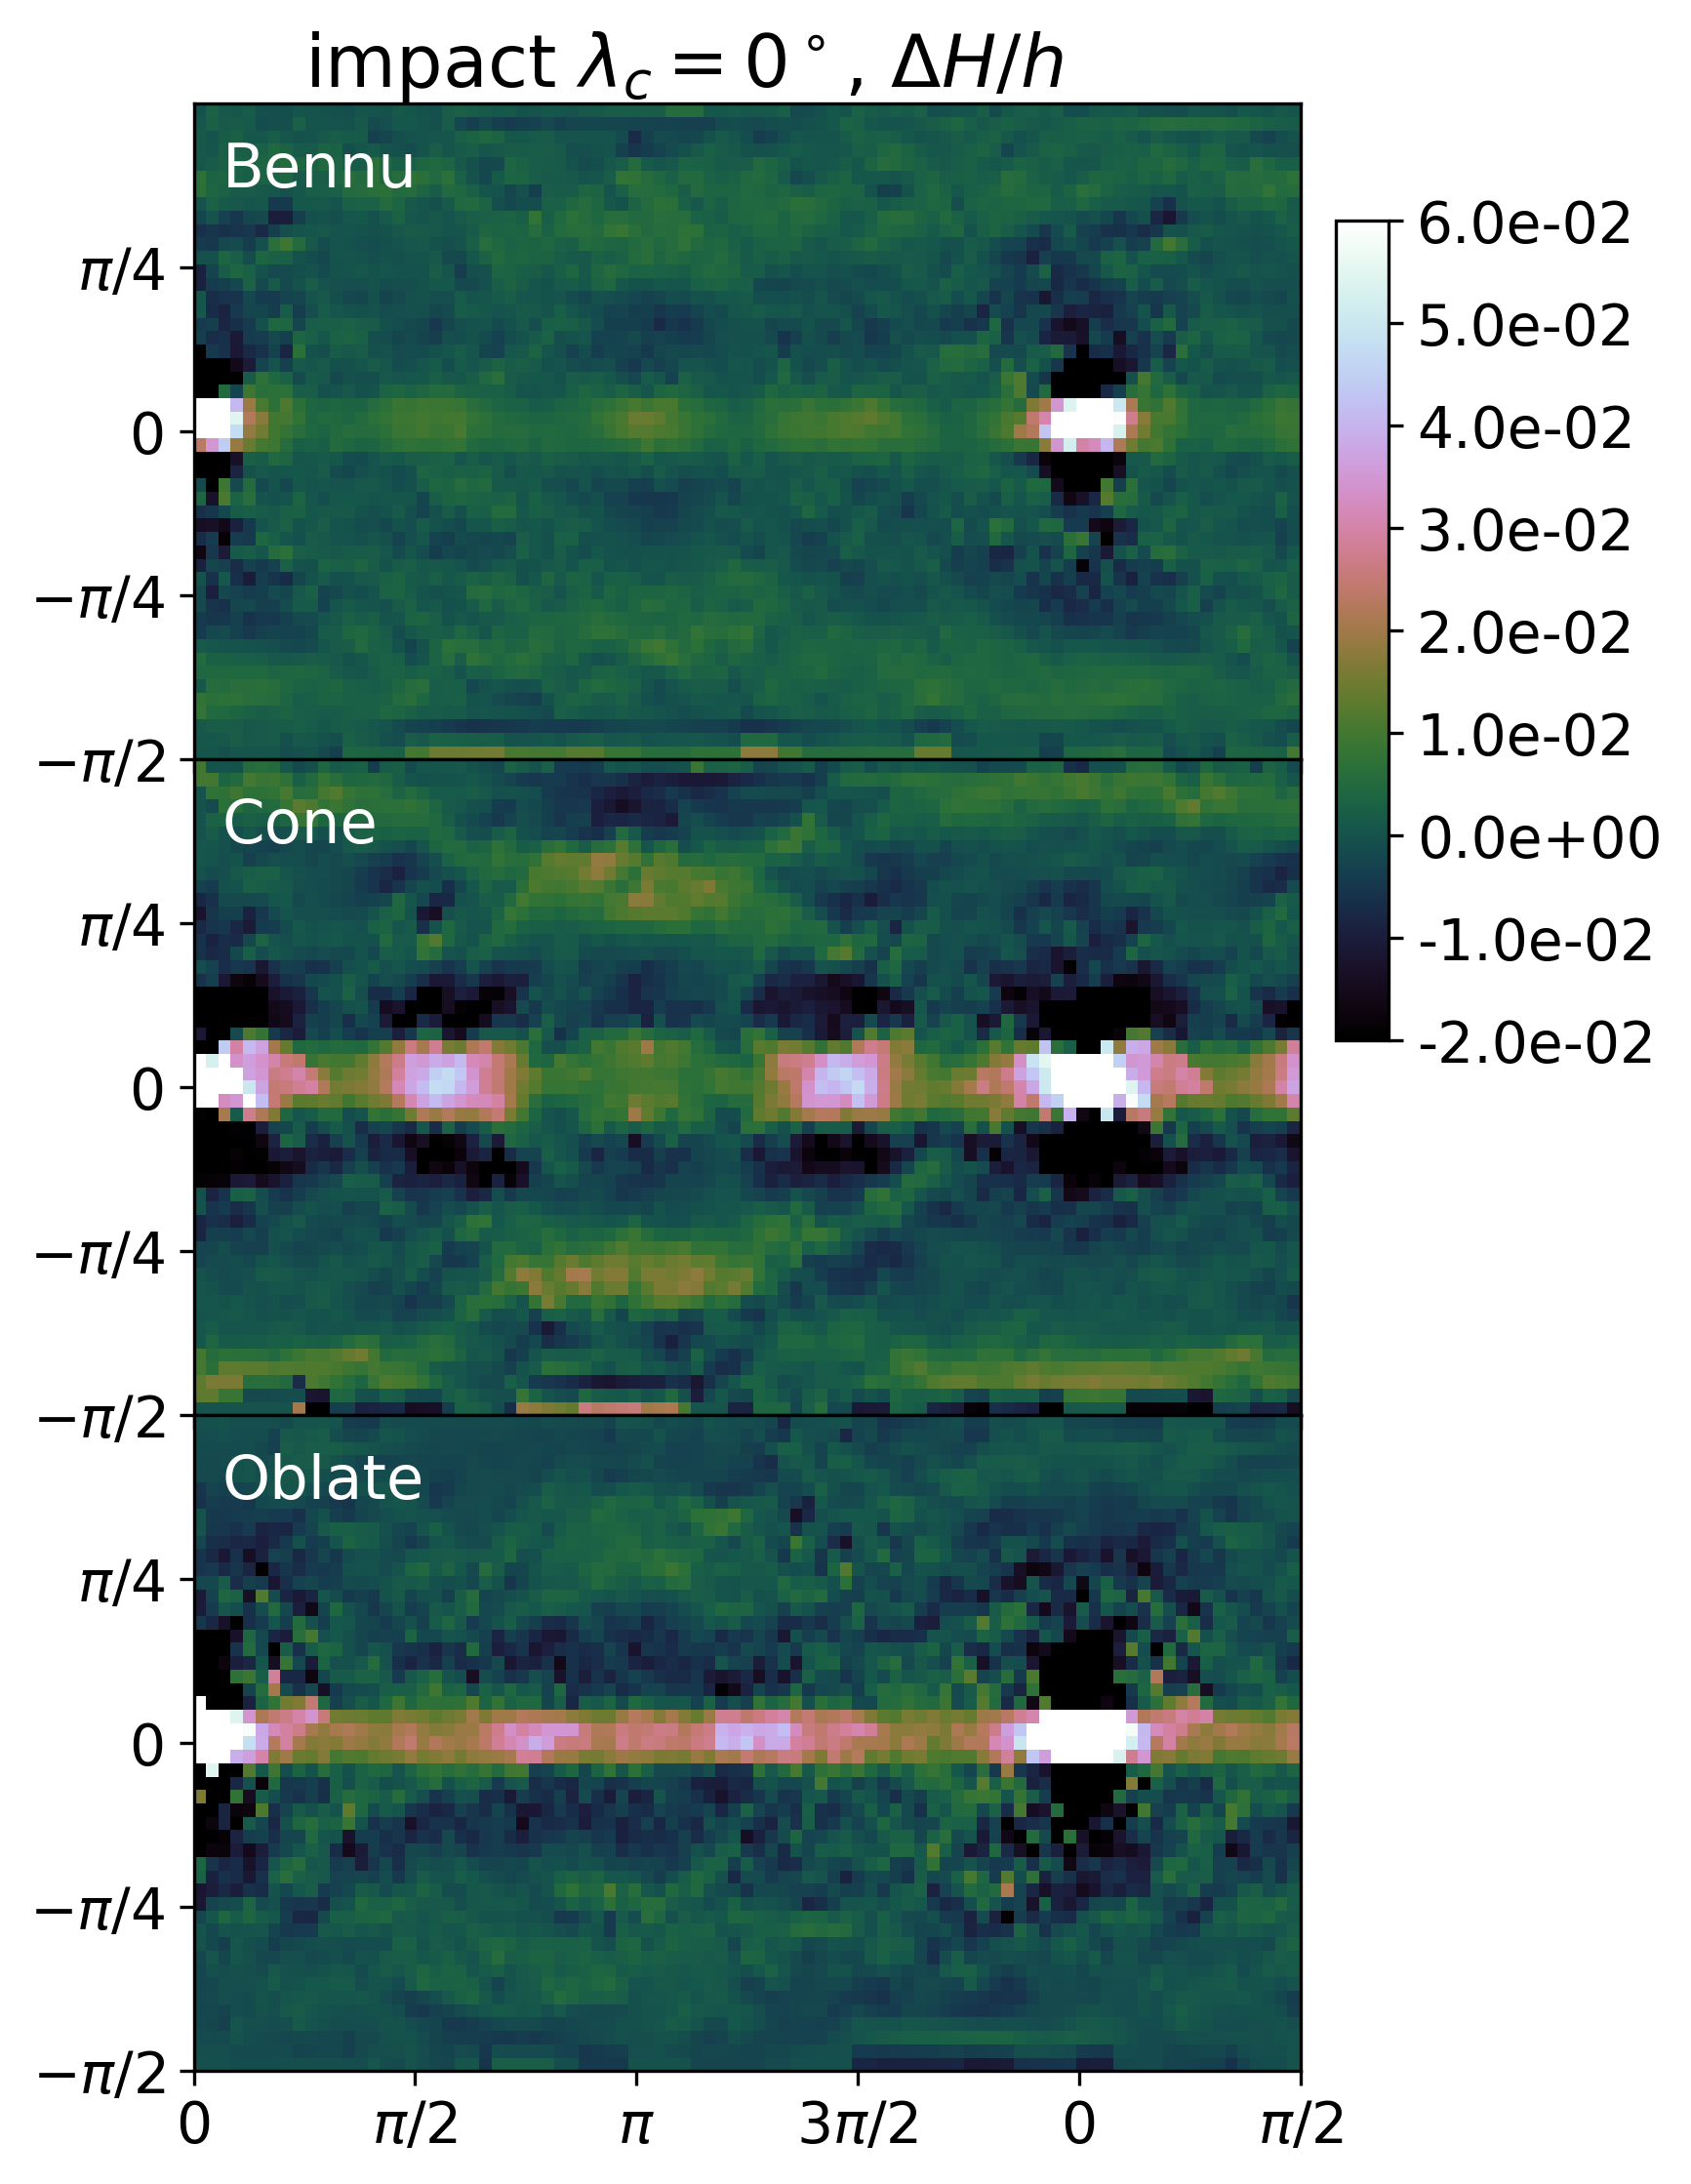

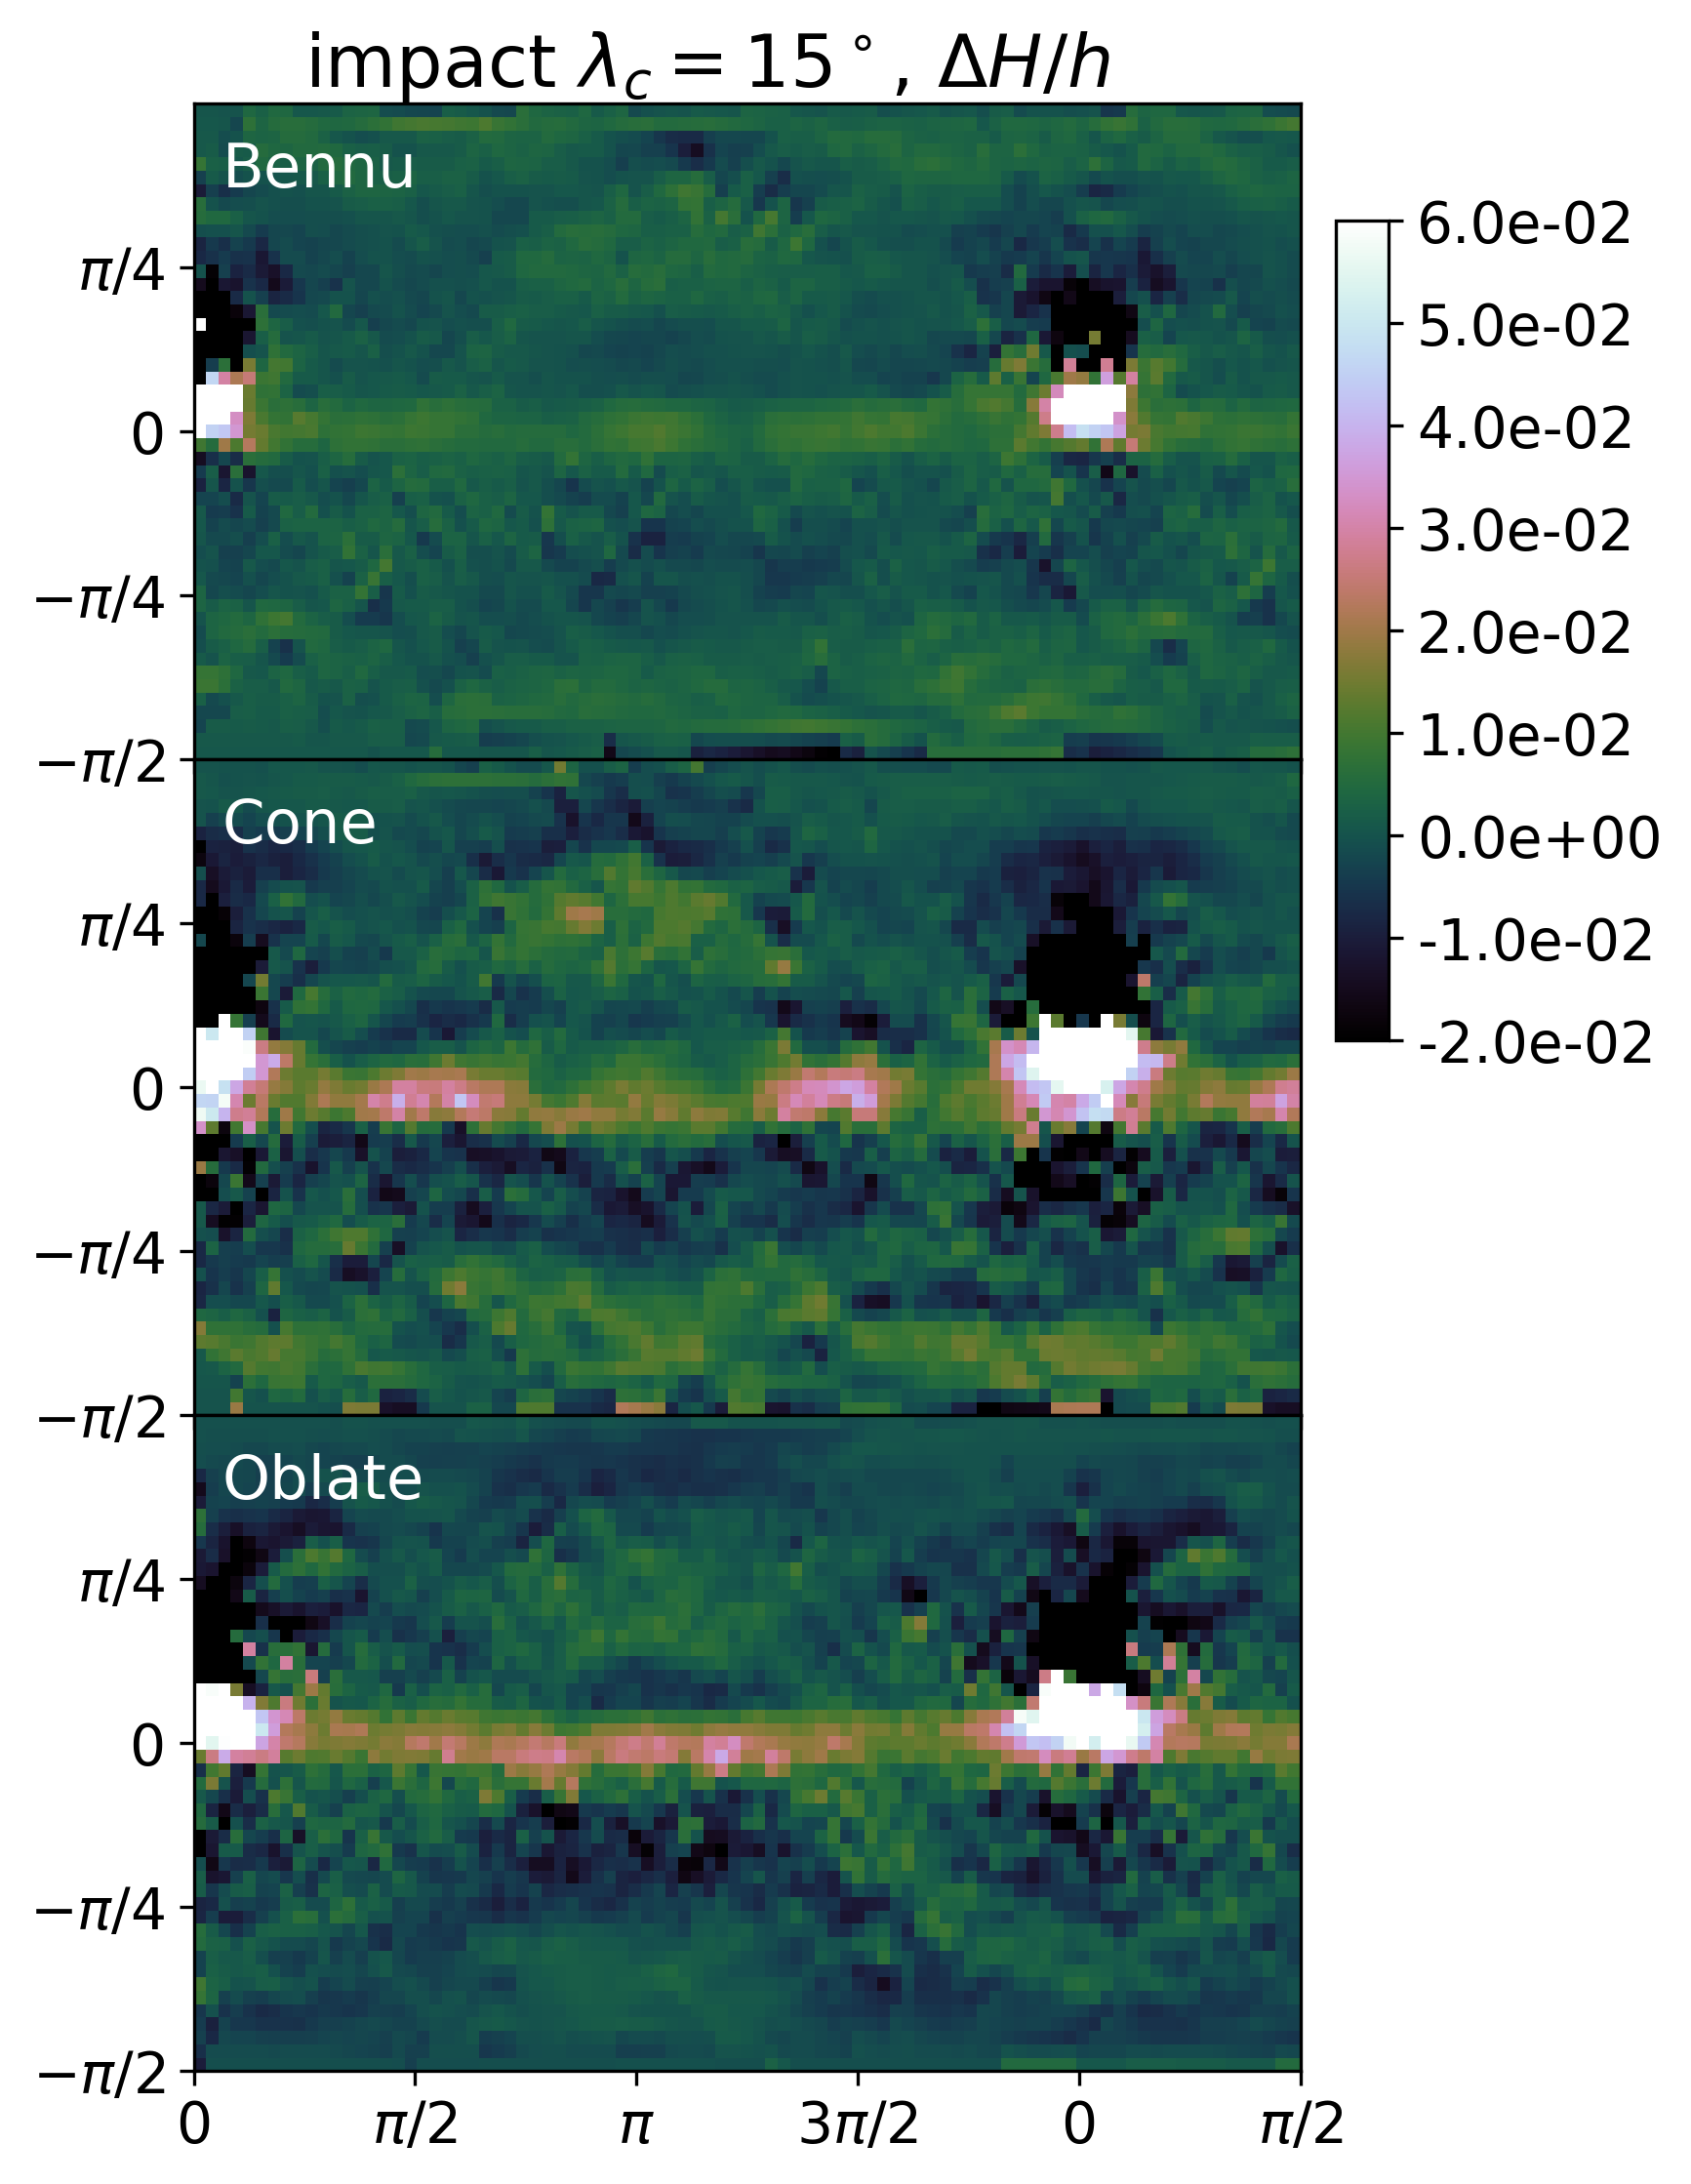

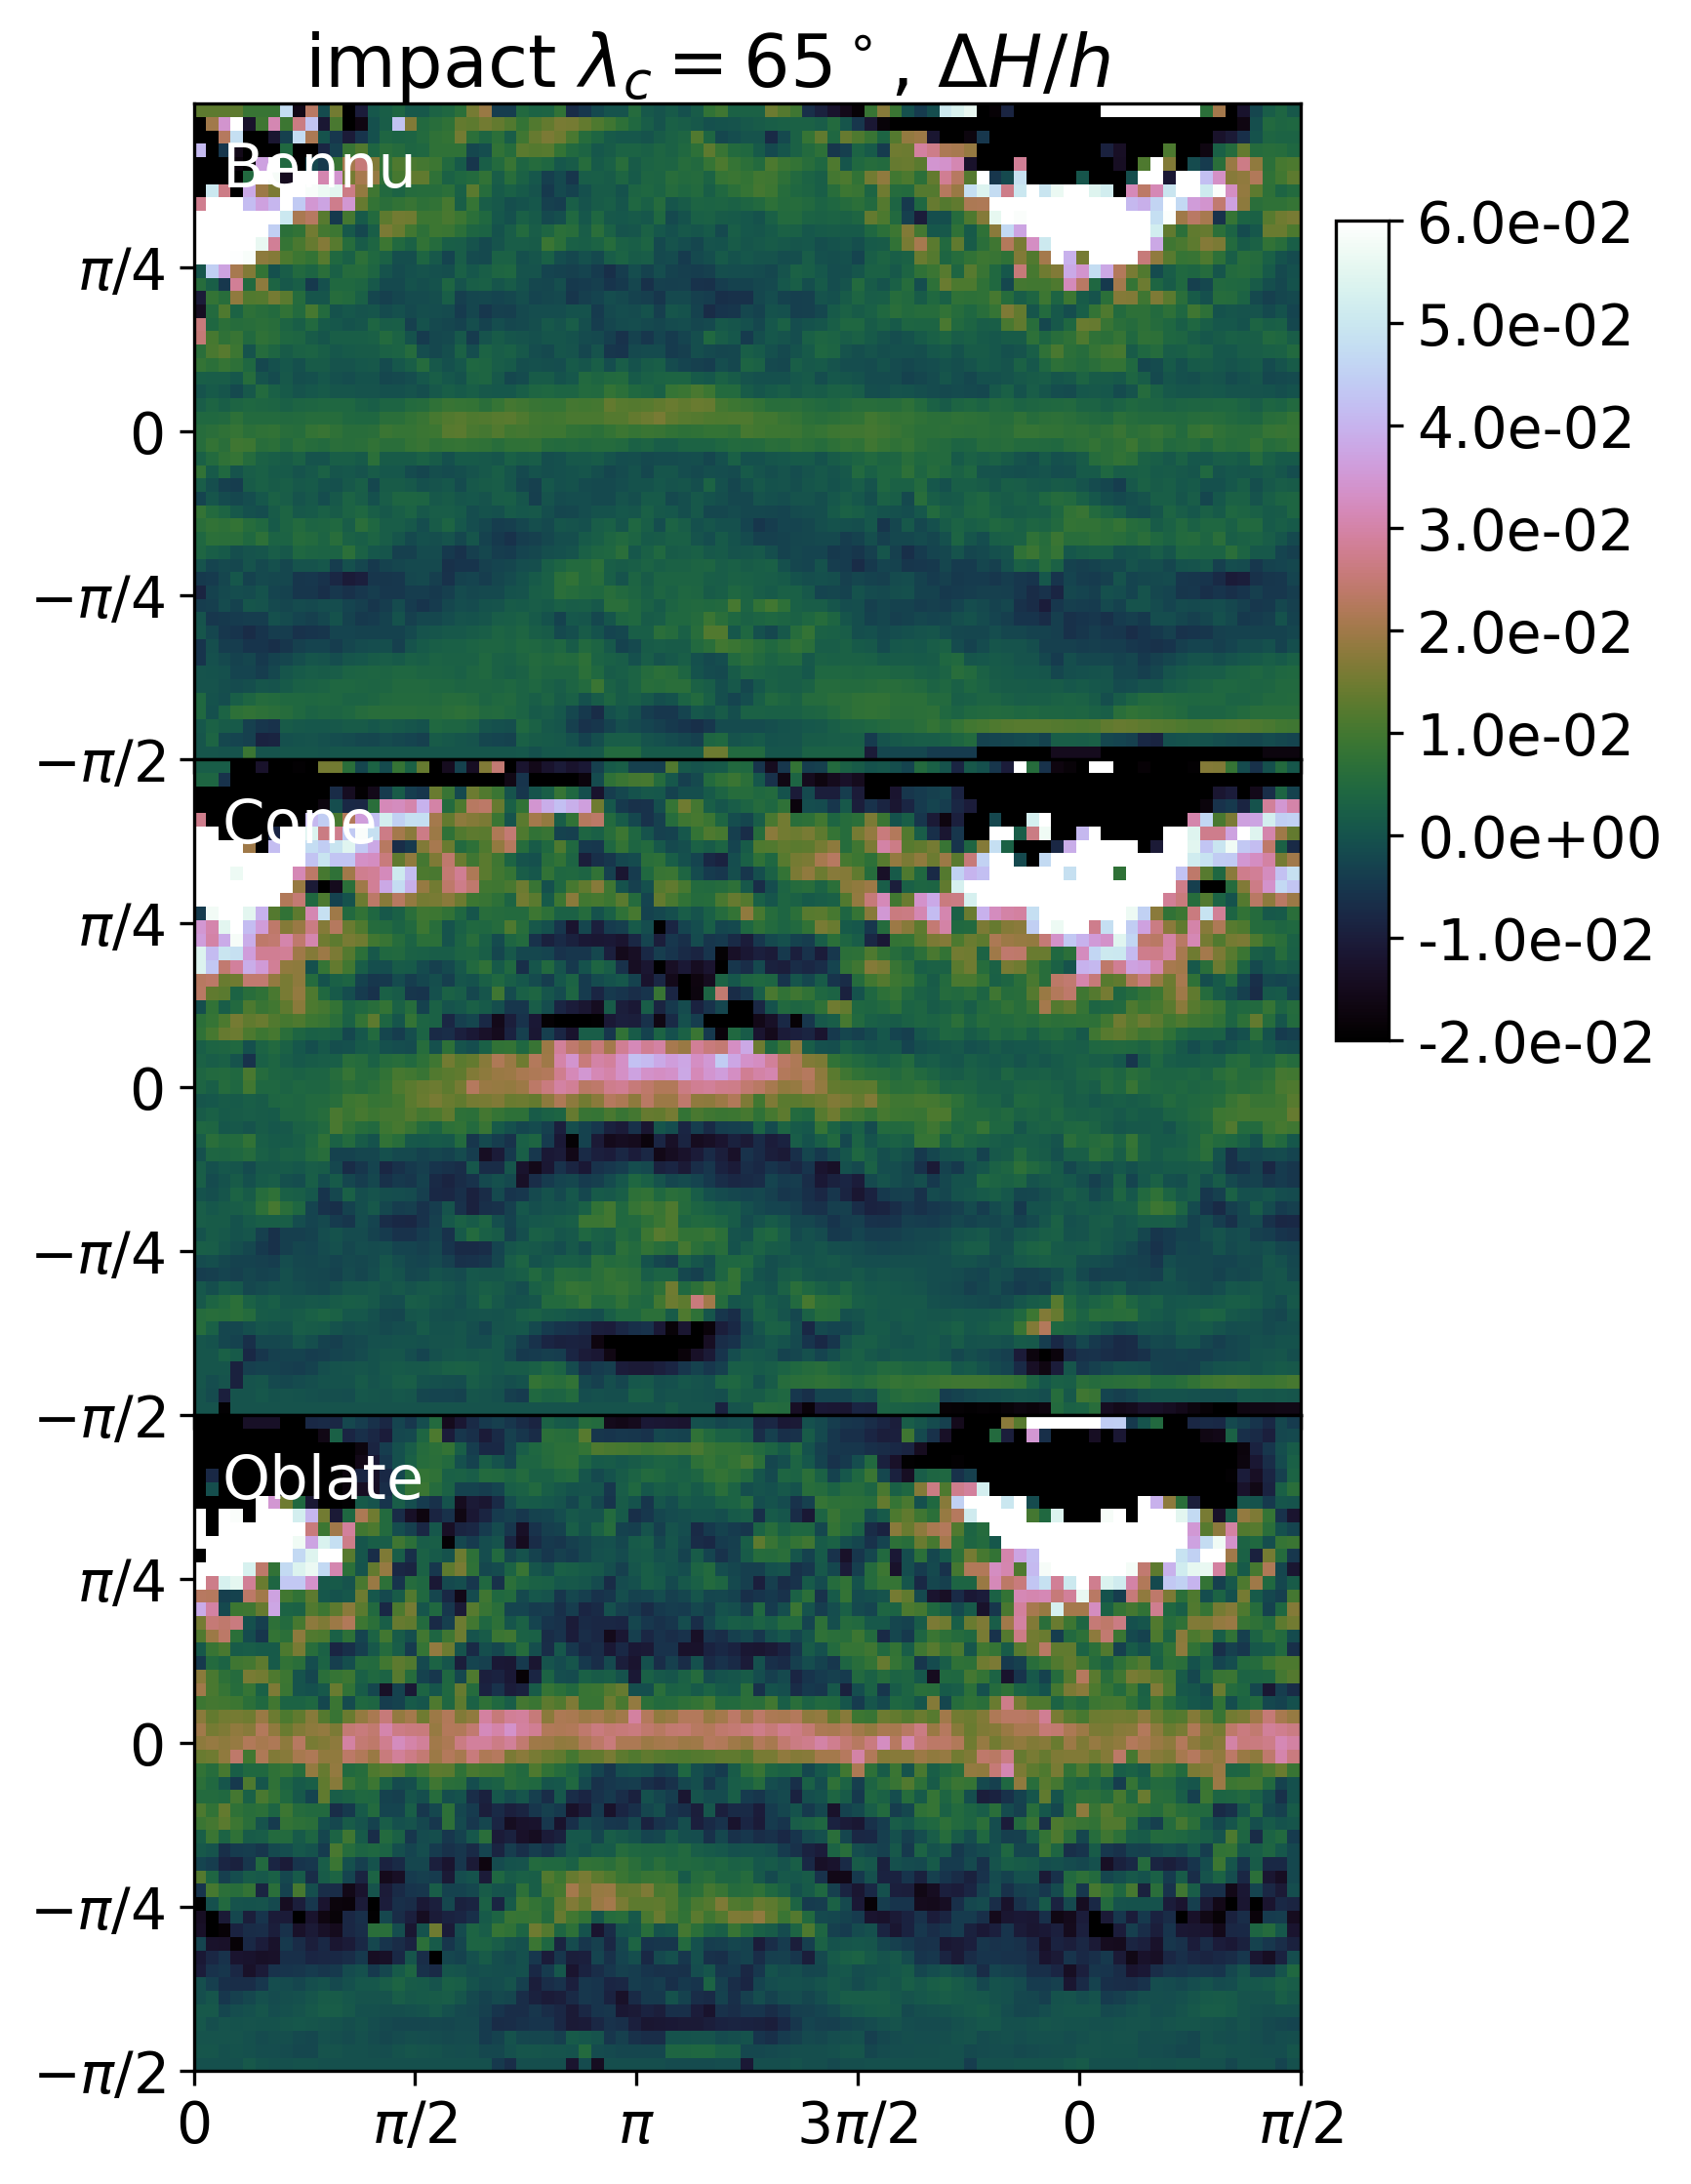

In [97]:
# short (out to 100)
    
g_comboo1,grad_s_comboo1=combo_short(g_maxvro1,g_ageoo1,g_betao_fix,g_sfaco1)
g_comboo2,grad_s_comboo2=combo_short(g_maxvro2,g_ageoo2,g_betao_fix,g_sfaco2)
g_comboo3,grad_s_comboo3=combo_short(g_maxvro3,g_ageoo3,g_betao_fix,g_sfaco3)  
g_comboc1,grad_s_comboc1=combo_short(g_maxvrc1,g_ageoc1,g_betac_fix,g_sfacc1) 
g_comboc2,grad_s_comboc2=combo_short(g_maxvrc2,g_ageoc2,g_betac_fix,g_sfacc2) 
g_comboc3,grad_s_comboc3=combo_short(g_maxvrc3,g_ageoc3,g_betac_fix,g_sfacc3)     
g_combob1,grad_s_combob1=combo_short(g_maxvrb1,g_ageob1,g_betab_fix,g_sfacb1)     
g_combob2,grad_s_combob2=combo_short(g_maxvrb2,g_ageob2,g_betab_fix,g_sfacb2)   
g_combob3,grad_s_combob3=combo_short(g_maxvrb3,g_ageob3,g_betab_fix,g_sfacb3)   


#plt3_grided(g_combob1,g_comboc1,g_comboo1, label_arr,-1e-4,1e-4,"")
#plt3_grided(g_combob2,g_comboc2,g_comboo2, label_arr,-1e-4,1e-4,"")
zmin=-2e-2; zmax=6e-2
plt3_grided(grad_s_combob1,grad_s_comboc1,grad_s_comboo1,label_arr,zmin,zmax,toplabel_0+max_label,"grad_eq_short.png")
plt3_grided(grad_s_combob2,grad_s_comboc2,grad_s_comboo2,label_arr,zmin,zmax,toplabel_15+max_label,"grad_15_short.png")
plt3_grided(grad_s_combob3,grad_s_comboc3,grad_s_comboo3,label_arr,zmin,zmax,toplabel_65+max_label,"grad_65_short.png")

In [27]:
#long, files otu to 899
npi = 0; npj=899
decayrate = 0.0

g_avev2o1_l,g_betao1_l,g_ageoo1_l,g_sfaco1_l,g_maxvro1_l = allfun(filerooto1,npi,npj,'o',decayrate)
g_avev2o2_l,g_betao2_l,g_ageoo2_l,g_sfaco2_l,g_maxvro2_l = allfun(filerooto2,npi,npj,'o',decayrate)
g_avev2o3_l,g_betao3_l,g_ageoo3_l,g_sfaco3_l,g_maxvro3_l = allfun(filerooto3,npi,npj,'o',decayrate)

g_avev2c1_l,g_betac1_l,g_ageoc1_l,g_sfacc1_l,g_maxvrc1_l = allfun(filerootc1,npi,npj,'c',decayrate)
g_avev2c2_l,g_betac2_l,g_ageoc2_l,g_sfacc2_l,g_maxvrc2_l = allfun(filerootc2,npi,npj,'c',decayrate)
g_avev2c3_l,g_betac3_l,g_ageoc3_l,g_sfacc3_l,g_maxvrc3_l = allfun(filerootc3,npi,npj,'c',decayrate)

g_avev2b1_l,g_betab1_l,g_ageob1_l,g_sfacb1_l,g_maxvrb1_l = allfun(filerootb1,npi,npj,'b',decayrate)
g_avev2b2_l,g_betab2_l,g_ageob2_l,g_sfacb2_l,g_maxvrb2_l = allfun(filerootb2,npi,npj,'b',decayrate)
g_avev2b3_l,g_betab3_l,g_ageob3_l,g_sfacb3_l,g_maxvrb3_l = allfun(filerootb3,npi,npj,'b',decayrate)



//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


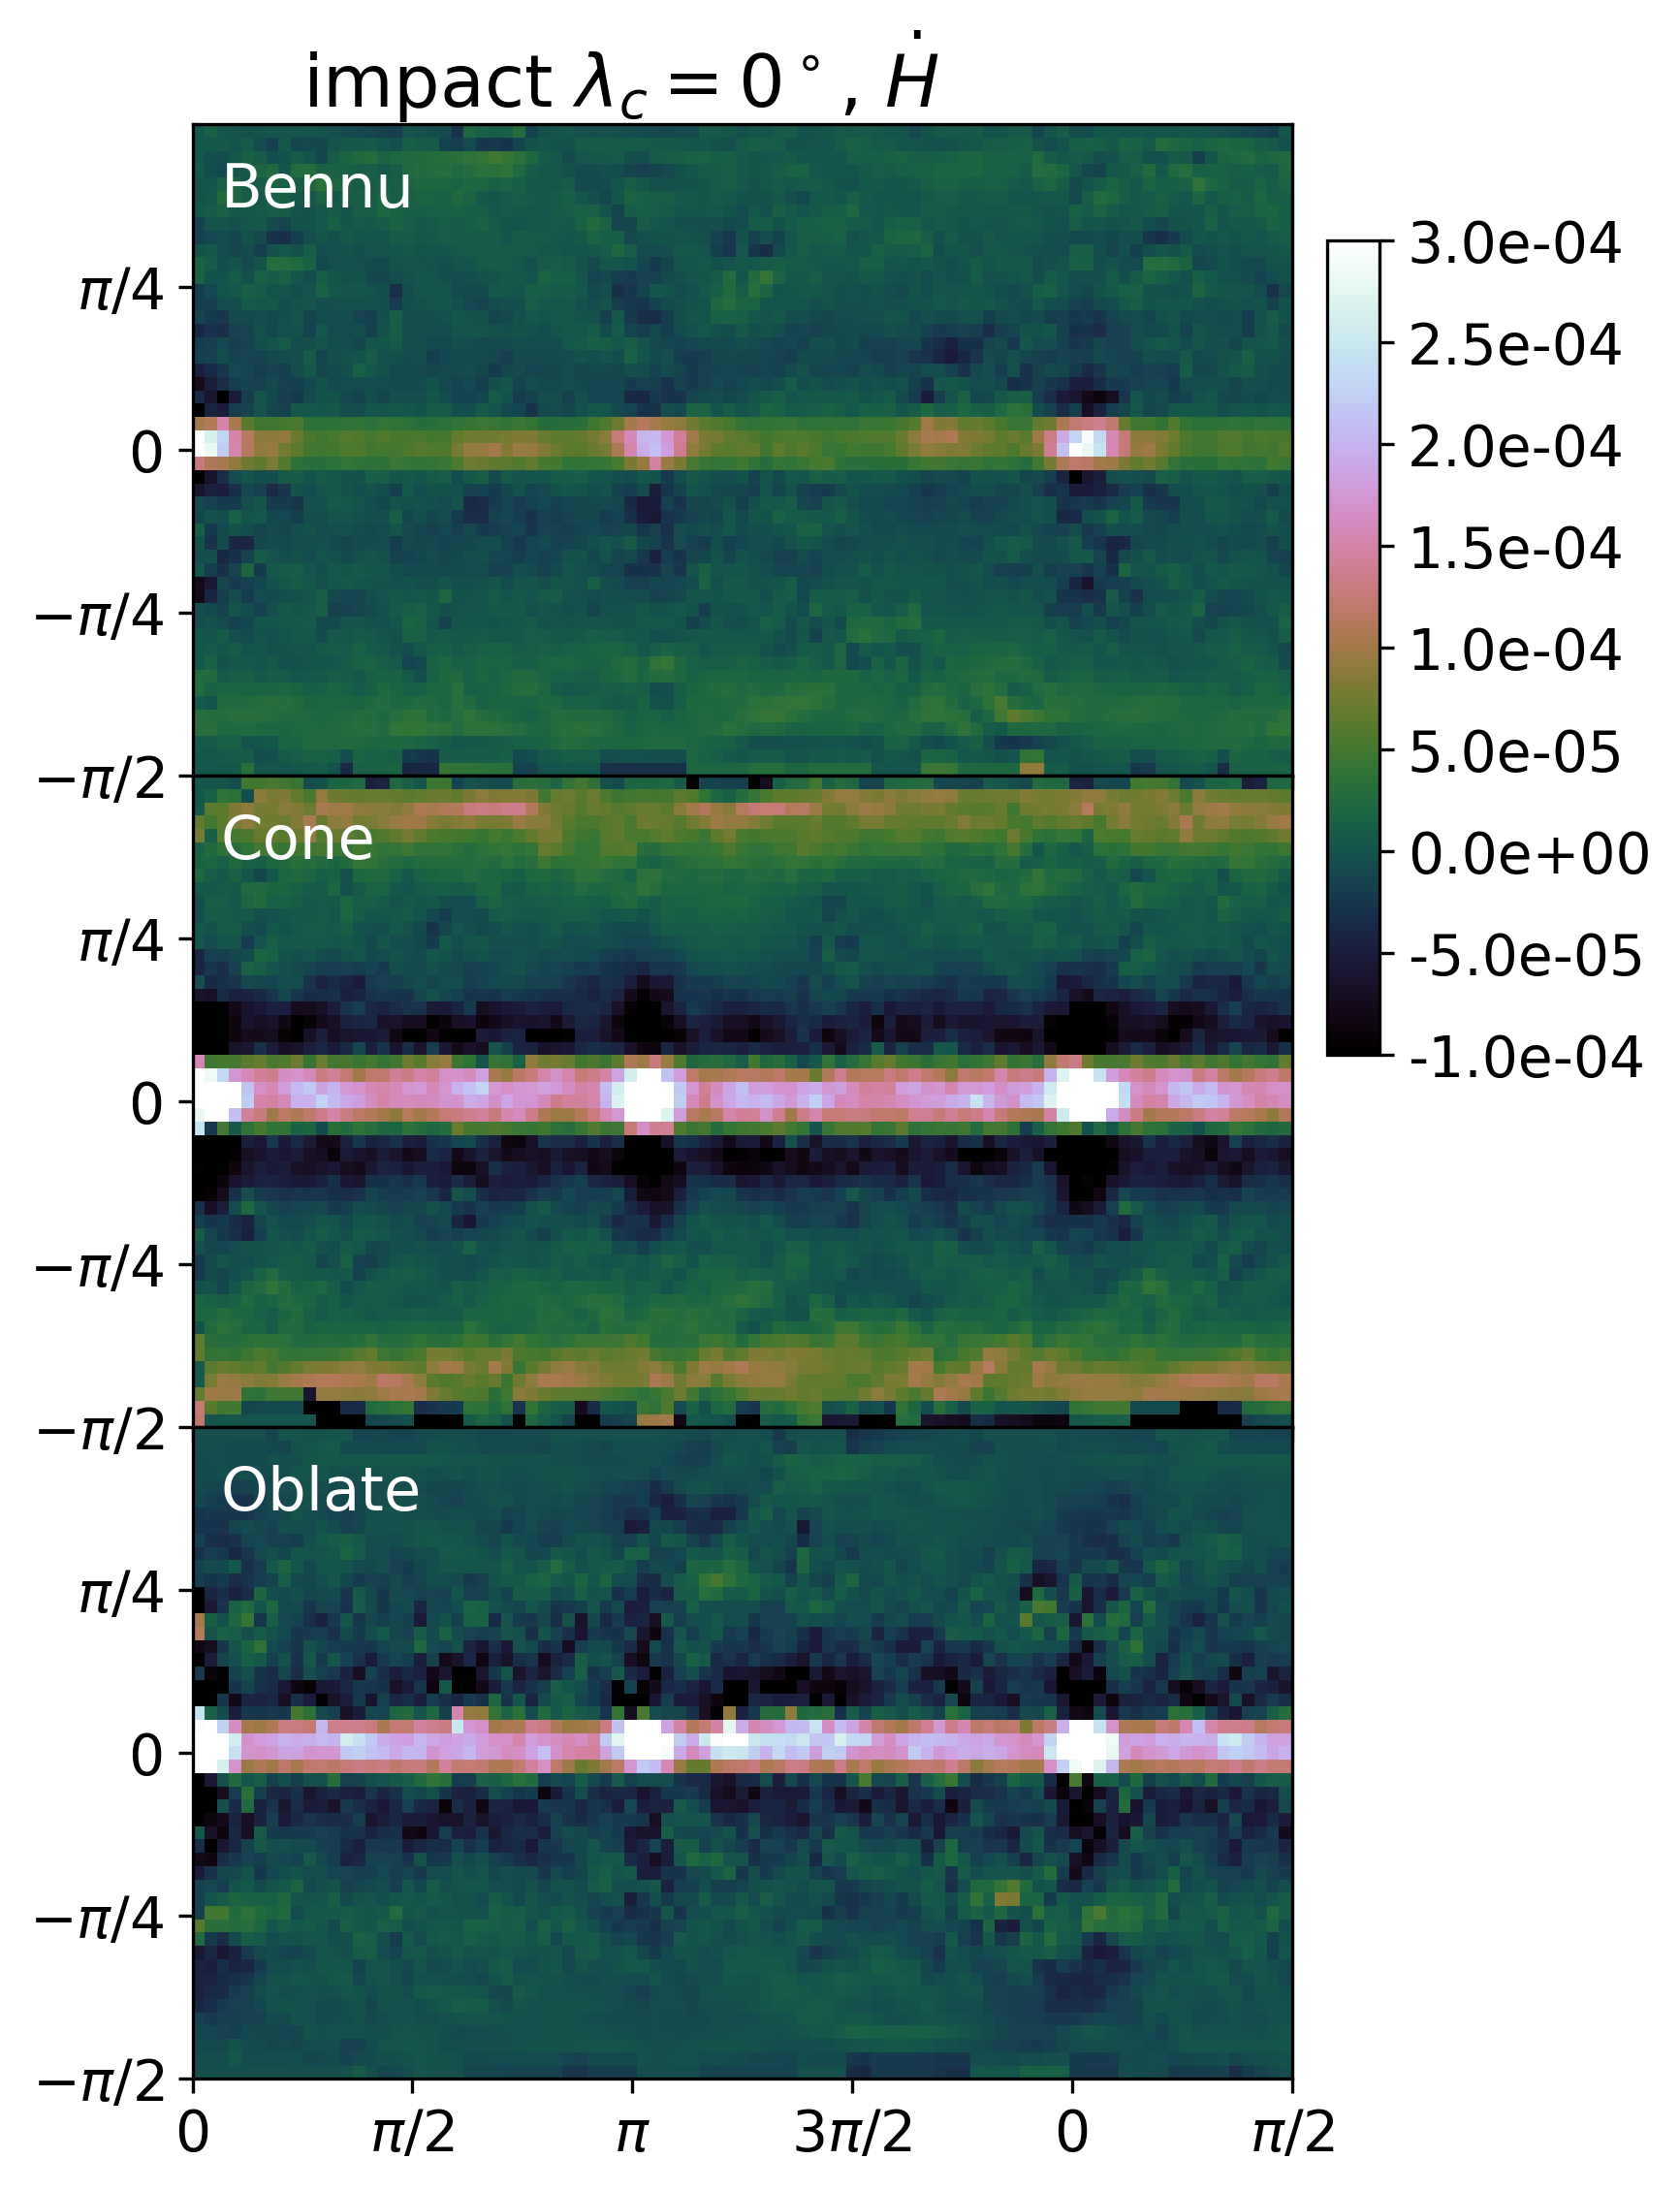

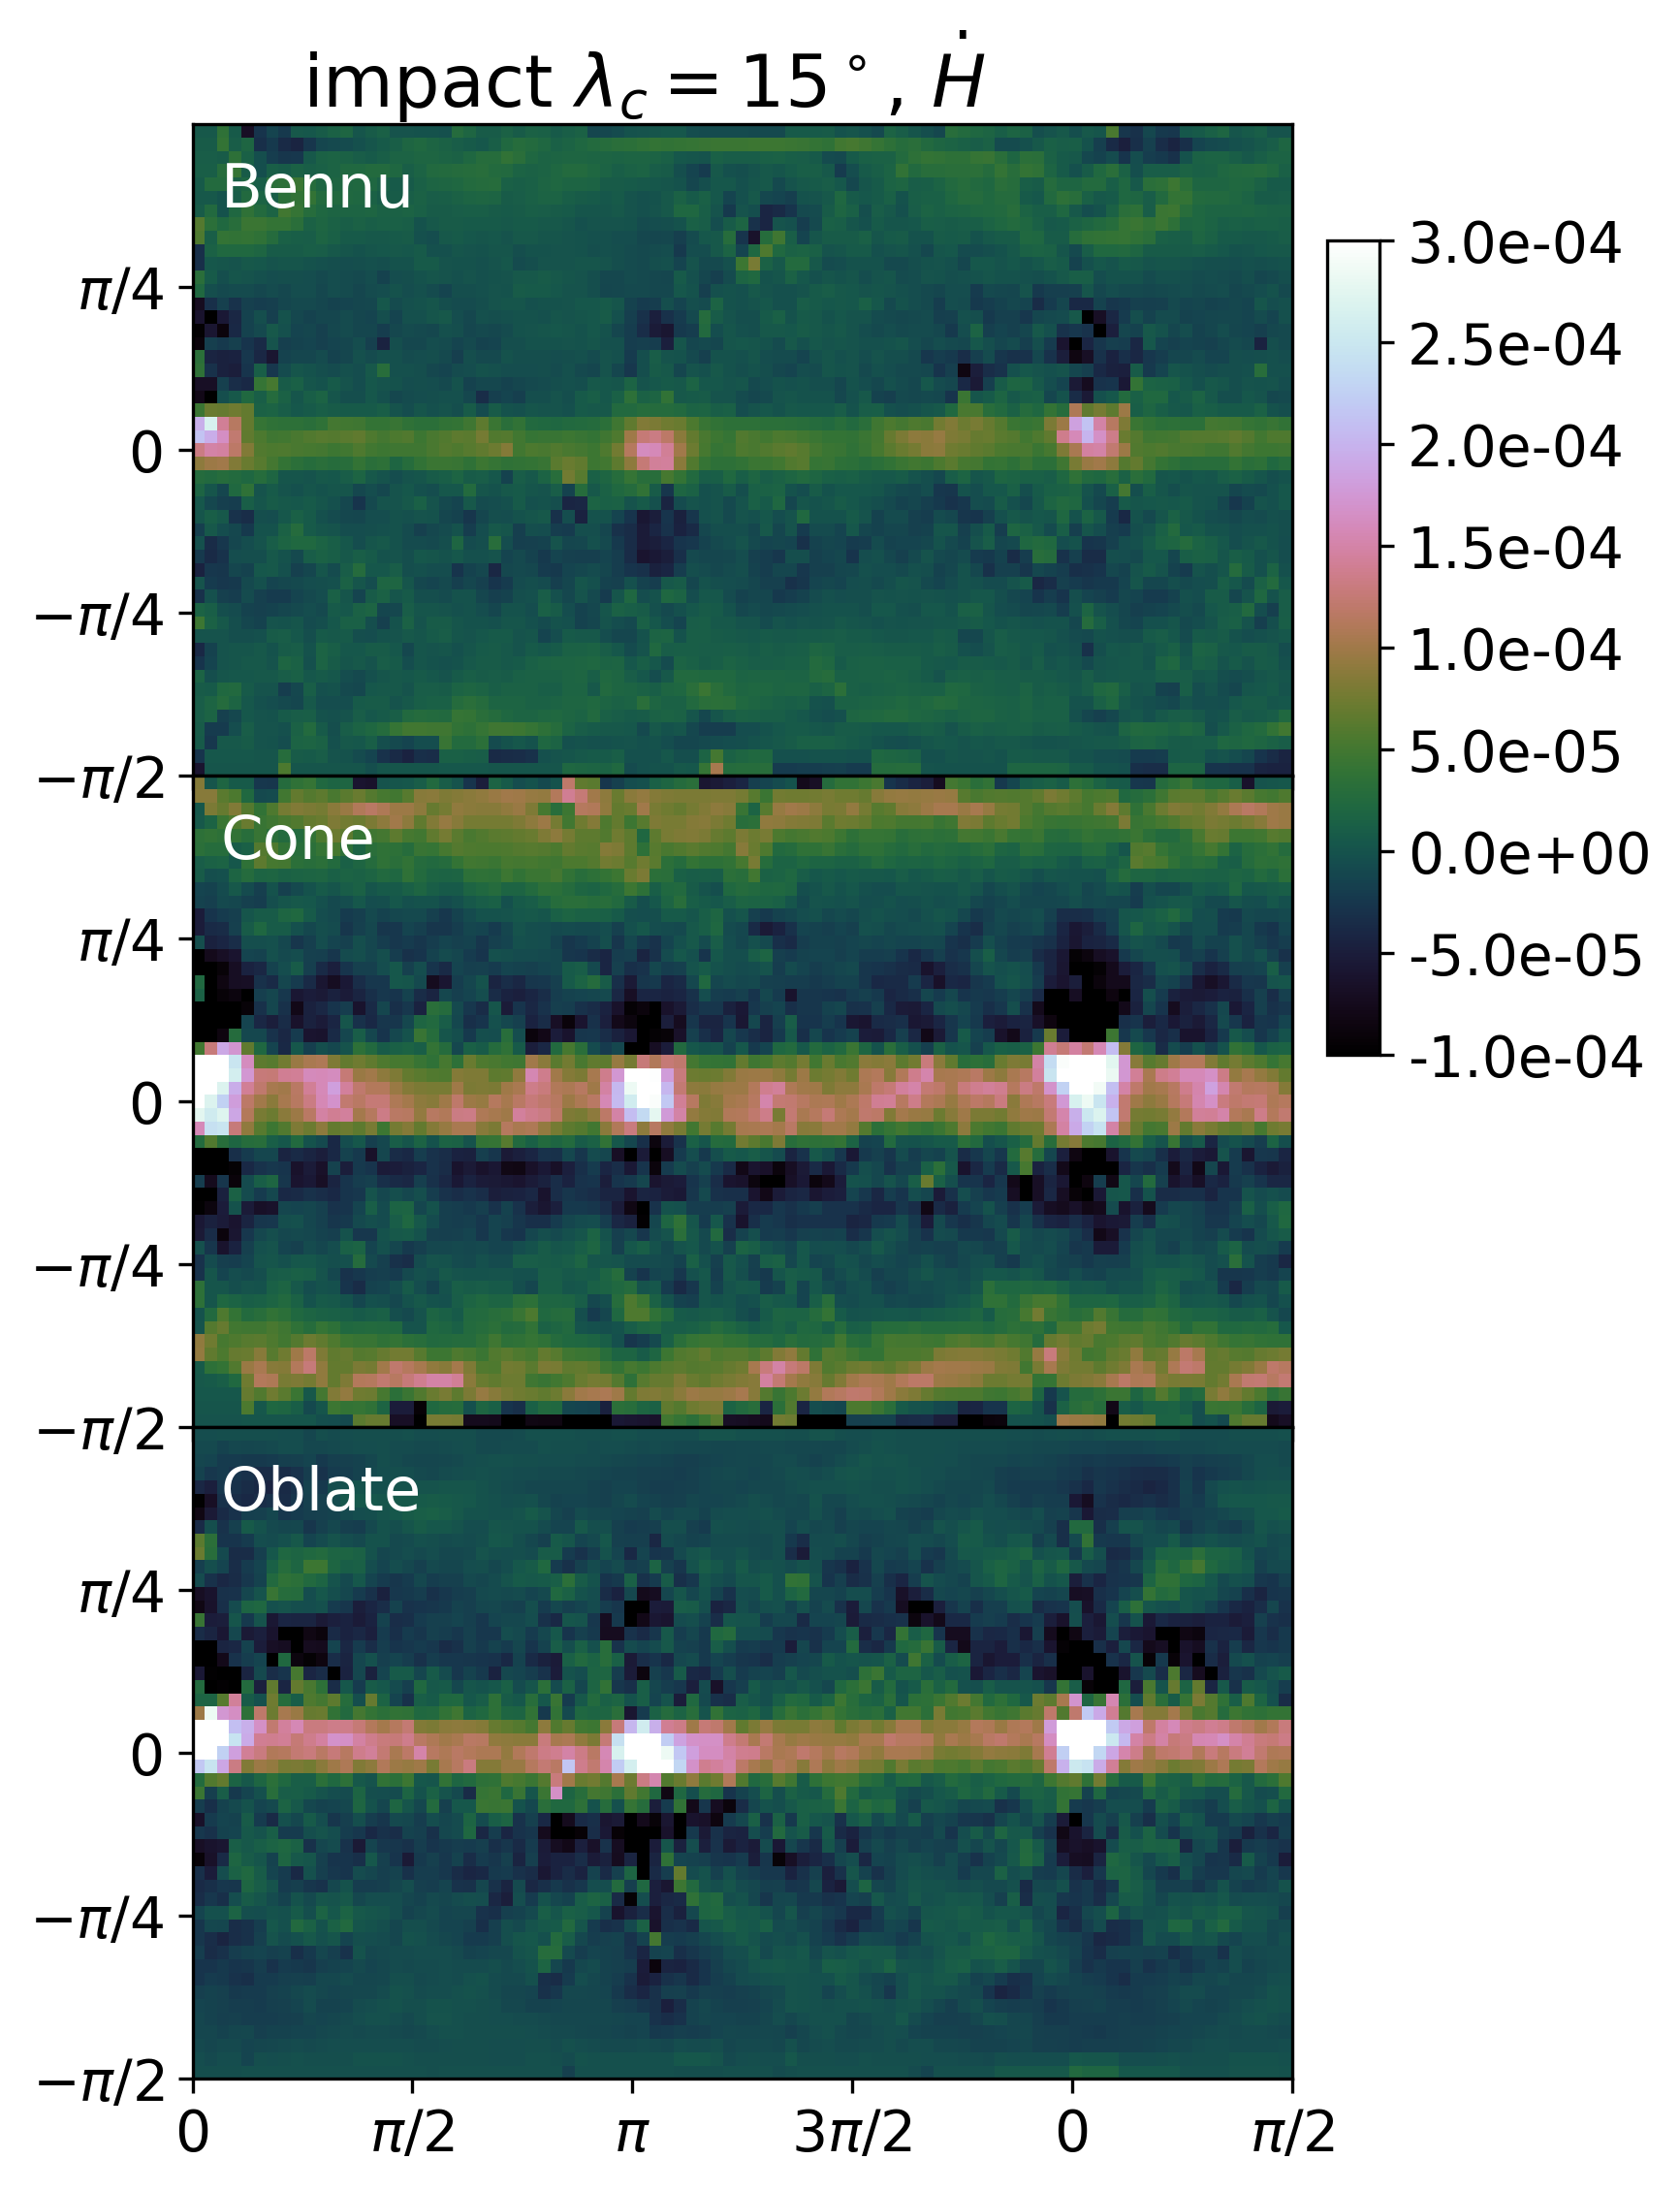

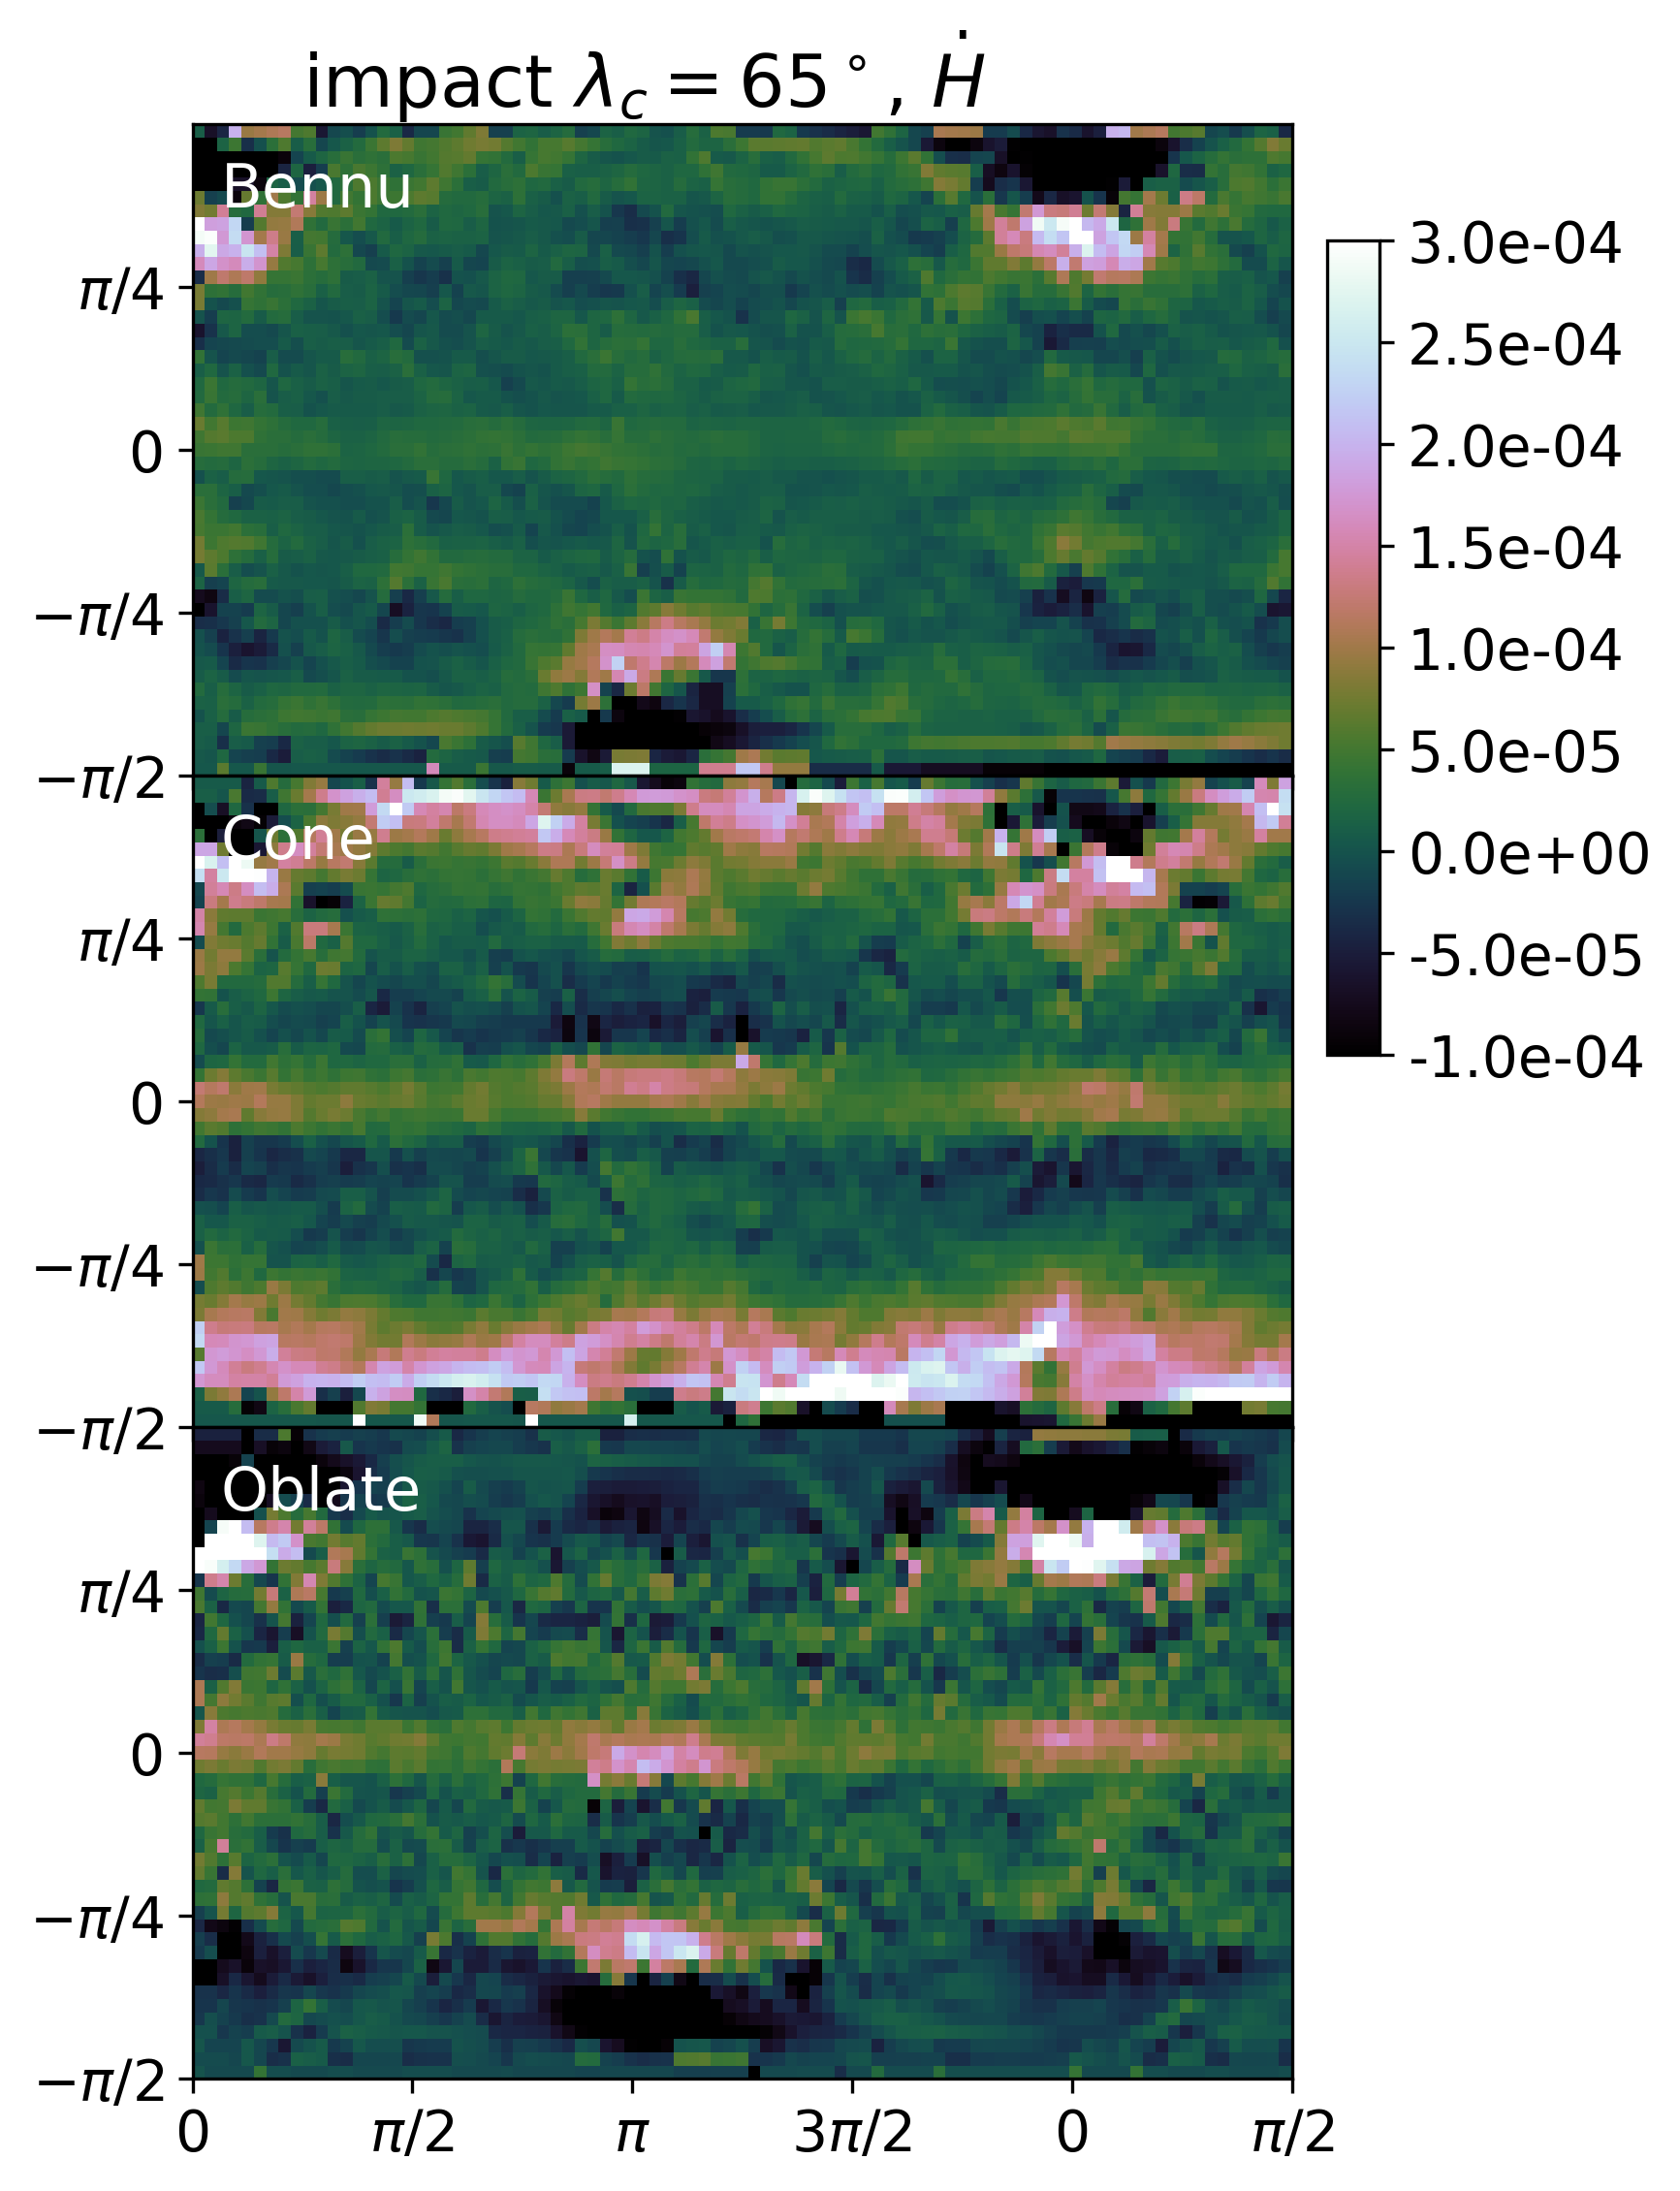

In [94]:

    
g_comboo1_l,grad_s_comboo1_l=combo_long(g_avev2o1_l,g_ageoo1_l,g_betao_fix,g_sfaco1_l)
g_comboo2_l,grad_s_comboo2_l=combo_long(g_avev2o2_l,g_ageoo2_l,g_betao_fix,g_sfaco2_l)
g_comboo3_l,grad_s_comboo3_l=combo_long(g_avev2o3_l,g_ageoo3_l,g_betao_fix,g_sfaco3_l)  
g_comboc1_l,grad_s_comboc1_l=combo_long(g_avev2c1_l,g_ageoc1_l,g_betac_fix,g_sfacc1_l) 
g_comboc2_l,grad_s_comboc2_l=combo_long(g_avev2c2_l,g_ageoc2_l,g_betac_fix,g_sfacc2_l) 
g_comboc3_l,grad_s_comboc3_l=combo_long(g_avev2c3_l,g_ageoc3_l,g_betac_fix,g_sfacc3_l)     
g_combob1_l,grad_s_combob1_l=combo_long(g_avev2b1_l,g_ageob1_l,g_betab_fix,g_sfacb1_l)     
g_combob2_l,grad_s_combob2_l=combo_long(g_avev2b2_l,g_ageob2_l,g_betab_fix,g_sfacb2_l)   
g_combob3_l,grad_s_combob3_l=combo_long(g_avev2b3_l,g_ageob3_l,g_betab_fix,g_sfacb3_l)   

zmin=-1e-4; zmax=3e-4;
plt3_grided(grad_s_combob1_l,grad_s_comboc1_l,grad_s_comboo1_l,label_arr,zmin,zmax,
            toplabel_0+vr_label,"grad_eq_long.png")
plt3_grided(grad_s_combob2_l,grad_s_comboc2_l,grad_s_comboo2_l,label_arr,zmin,zmax,
            toplabel_15+vr_label,"grad_15_long.png")
plt3_grided(grad_s_combob3_l,grad_s_comboc3_l,grad_s_comboo3_l,label_arr,zmin,zmax,
            toplabel_65+vr_label,"grad_65_long.png")

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


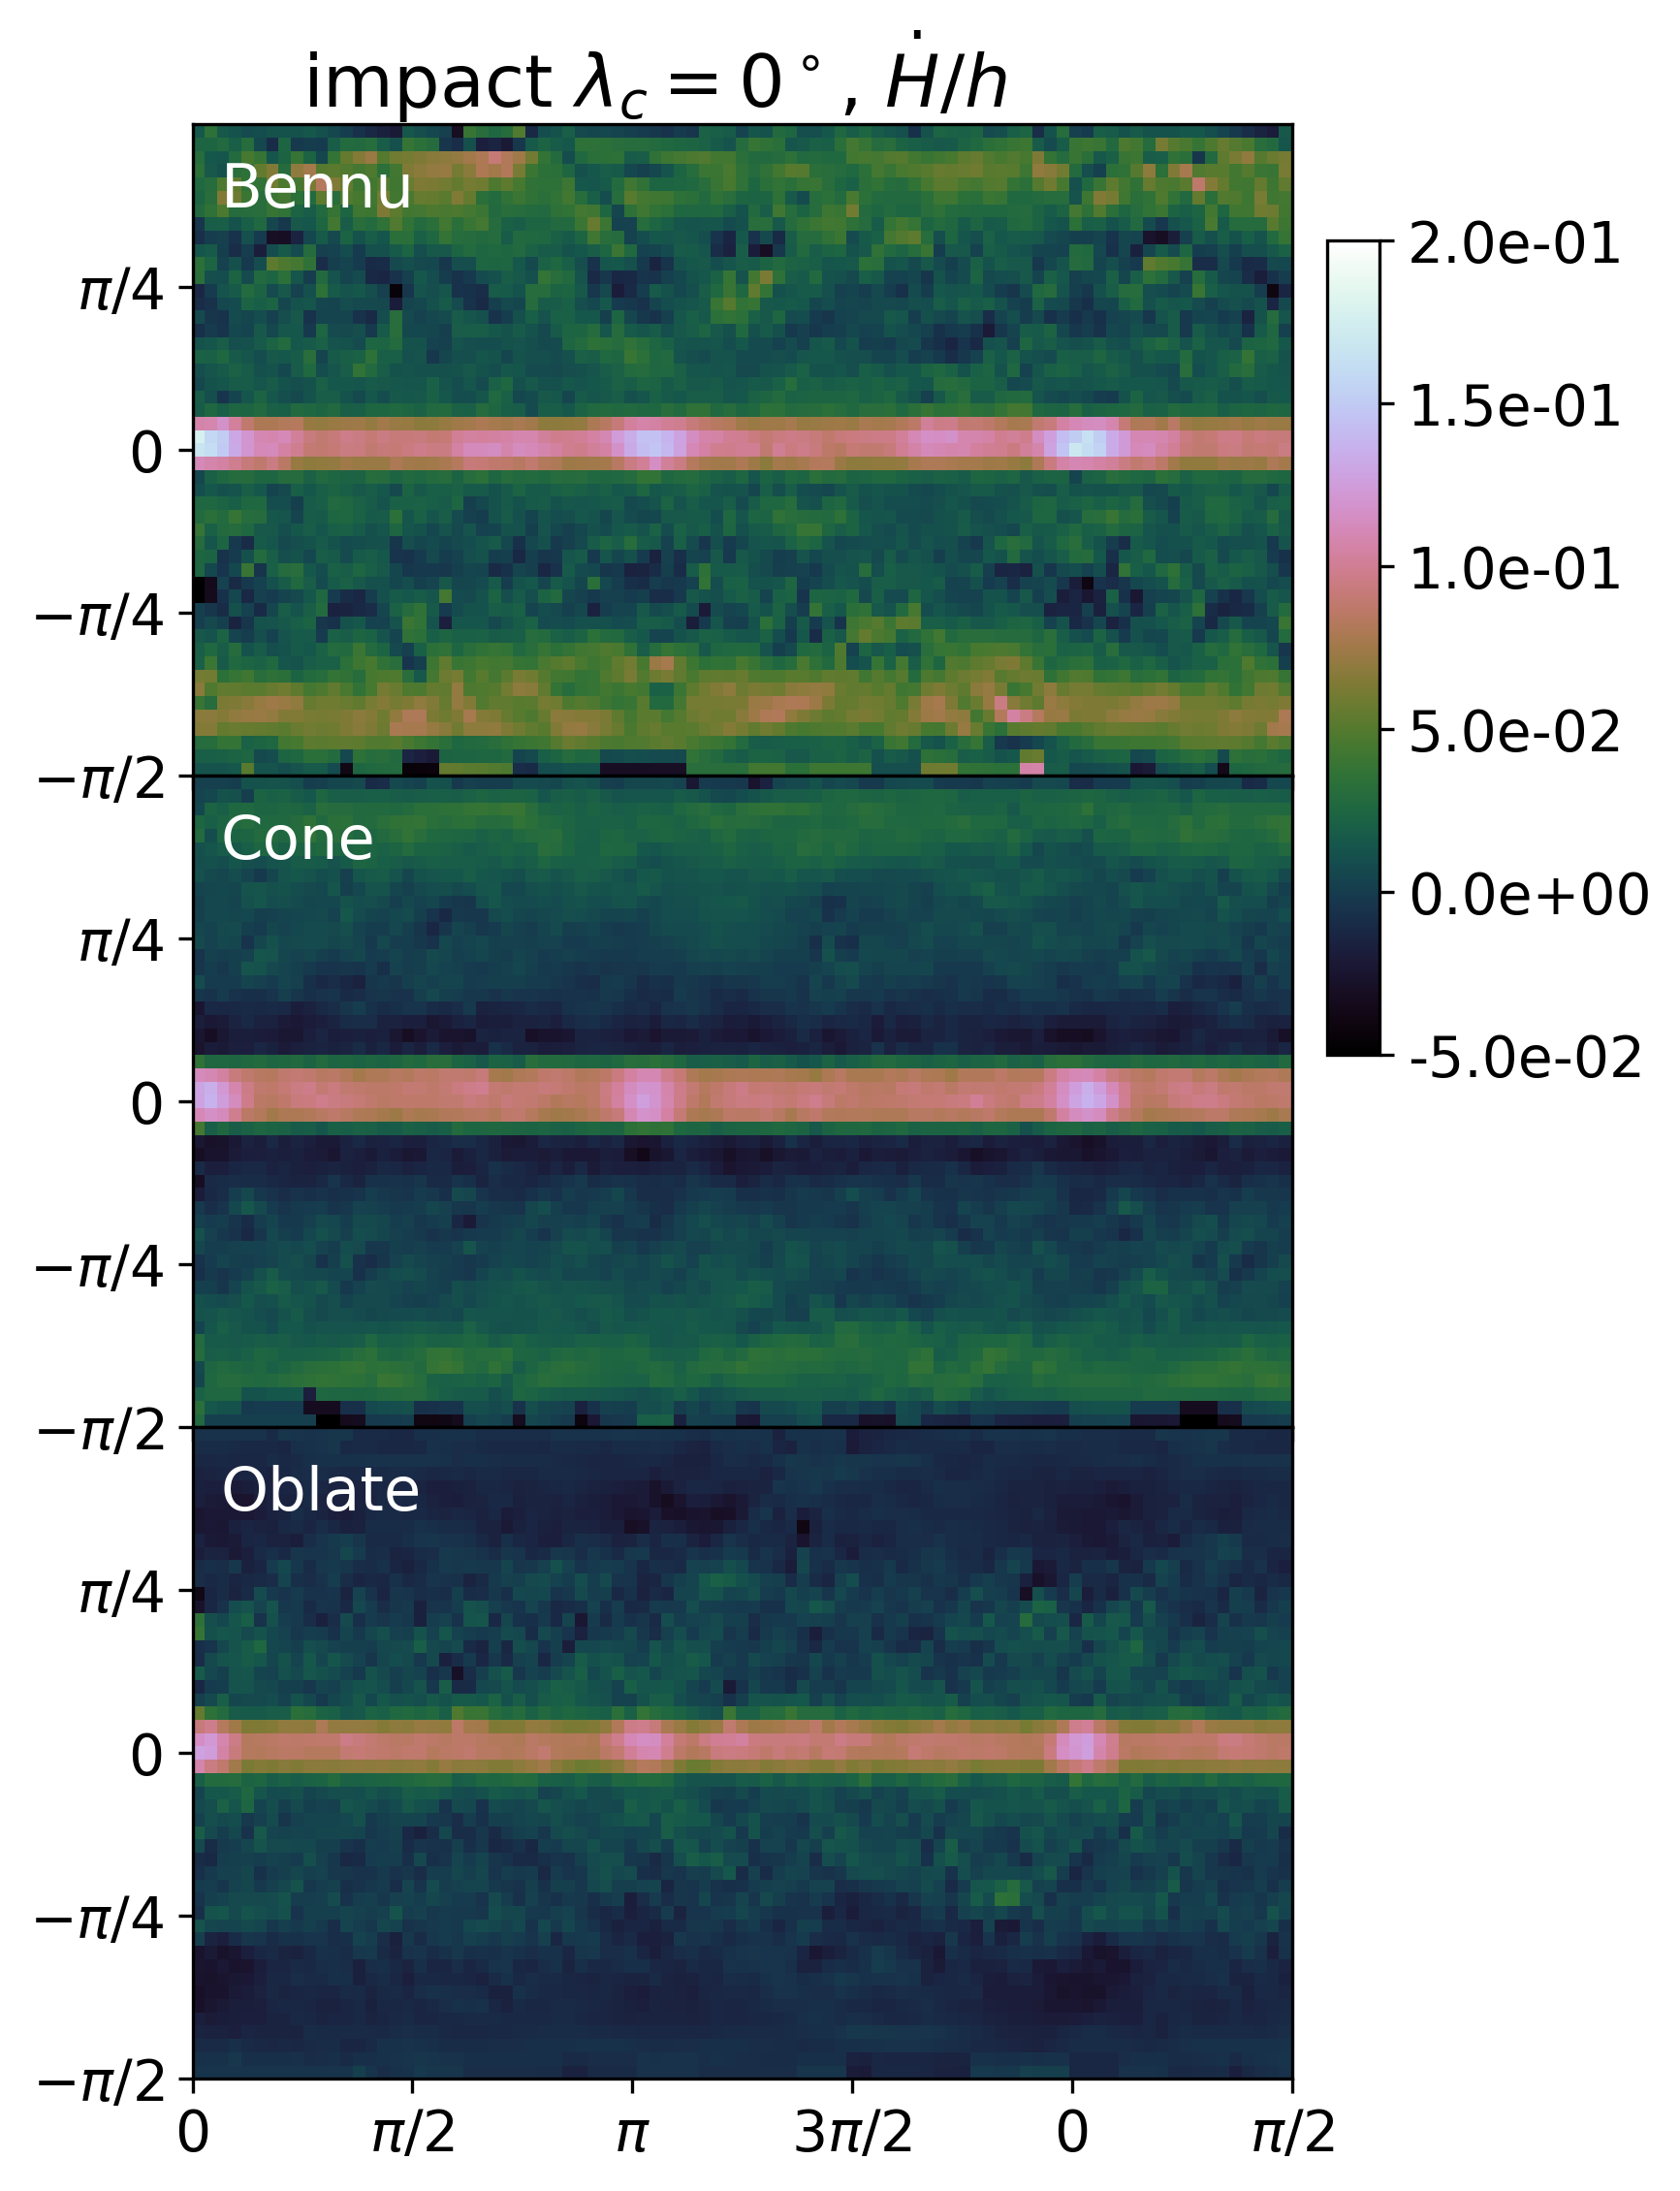

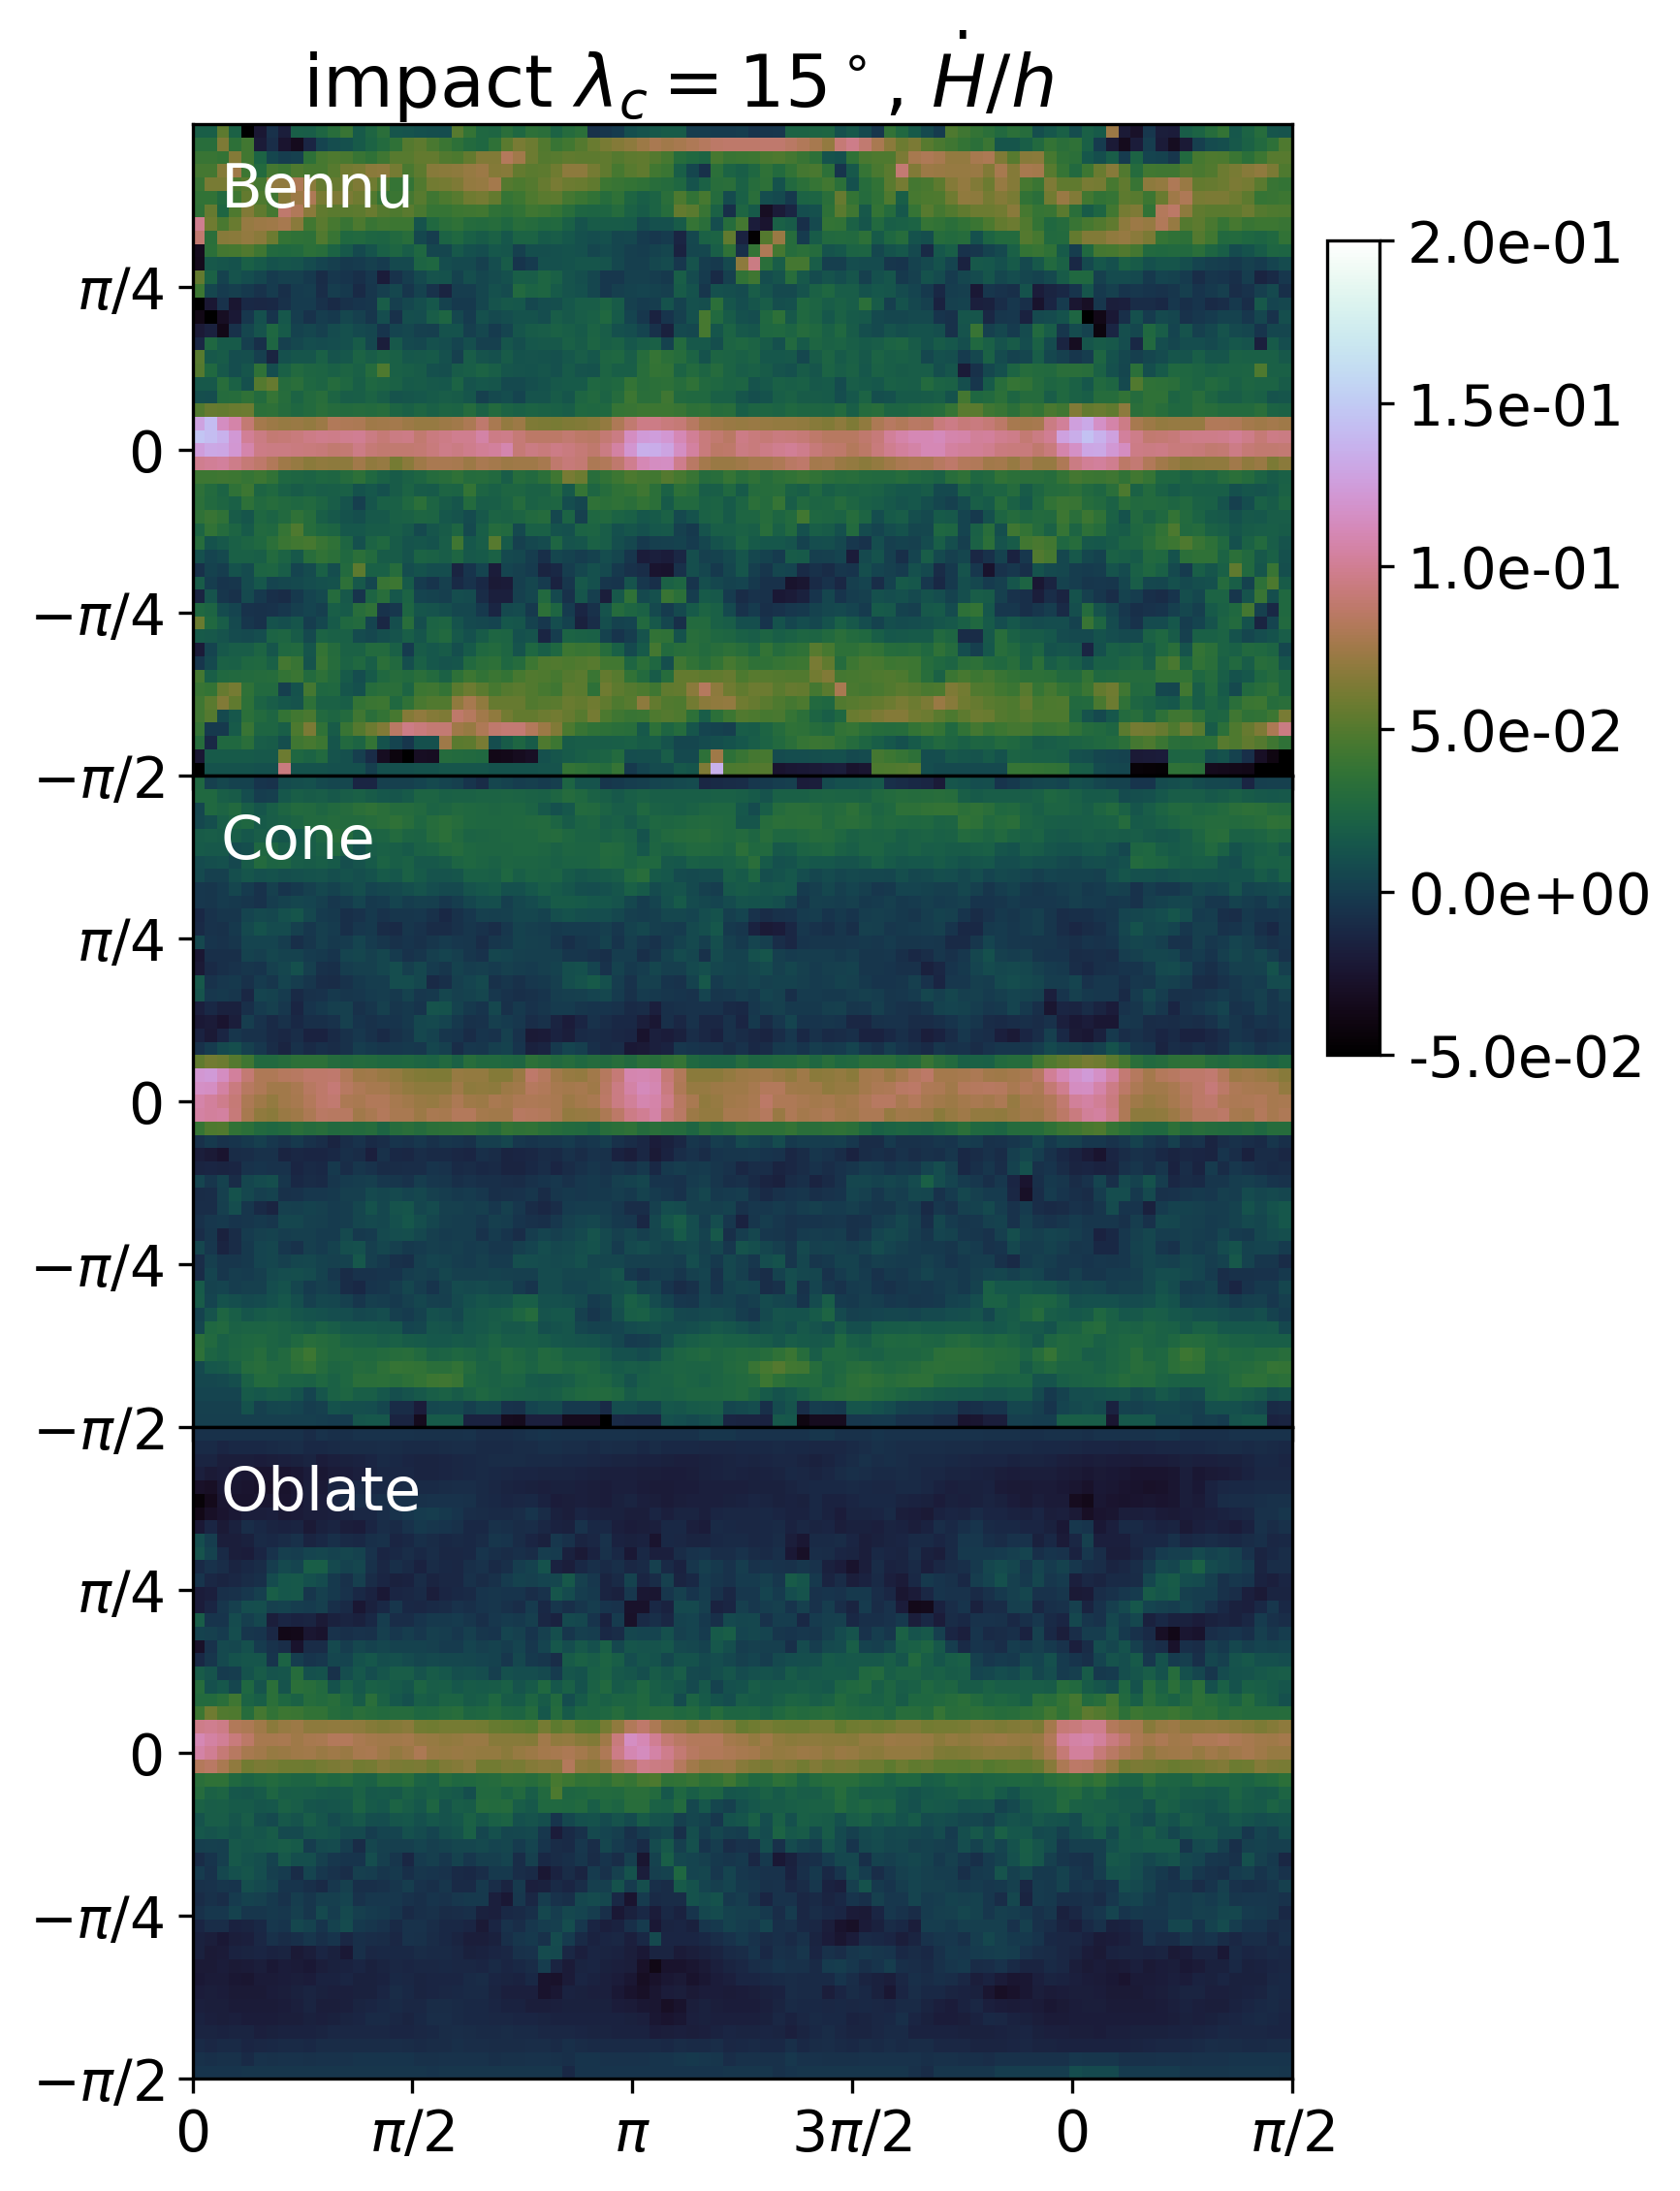

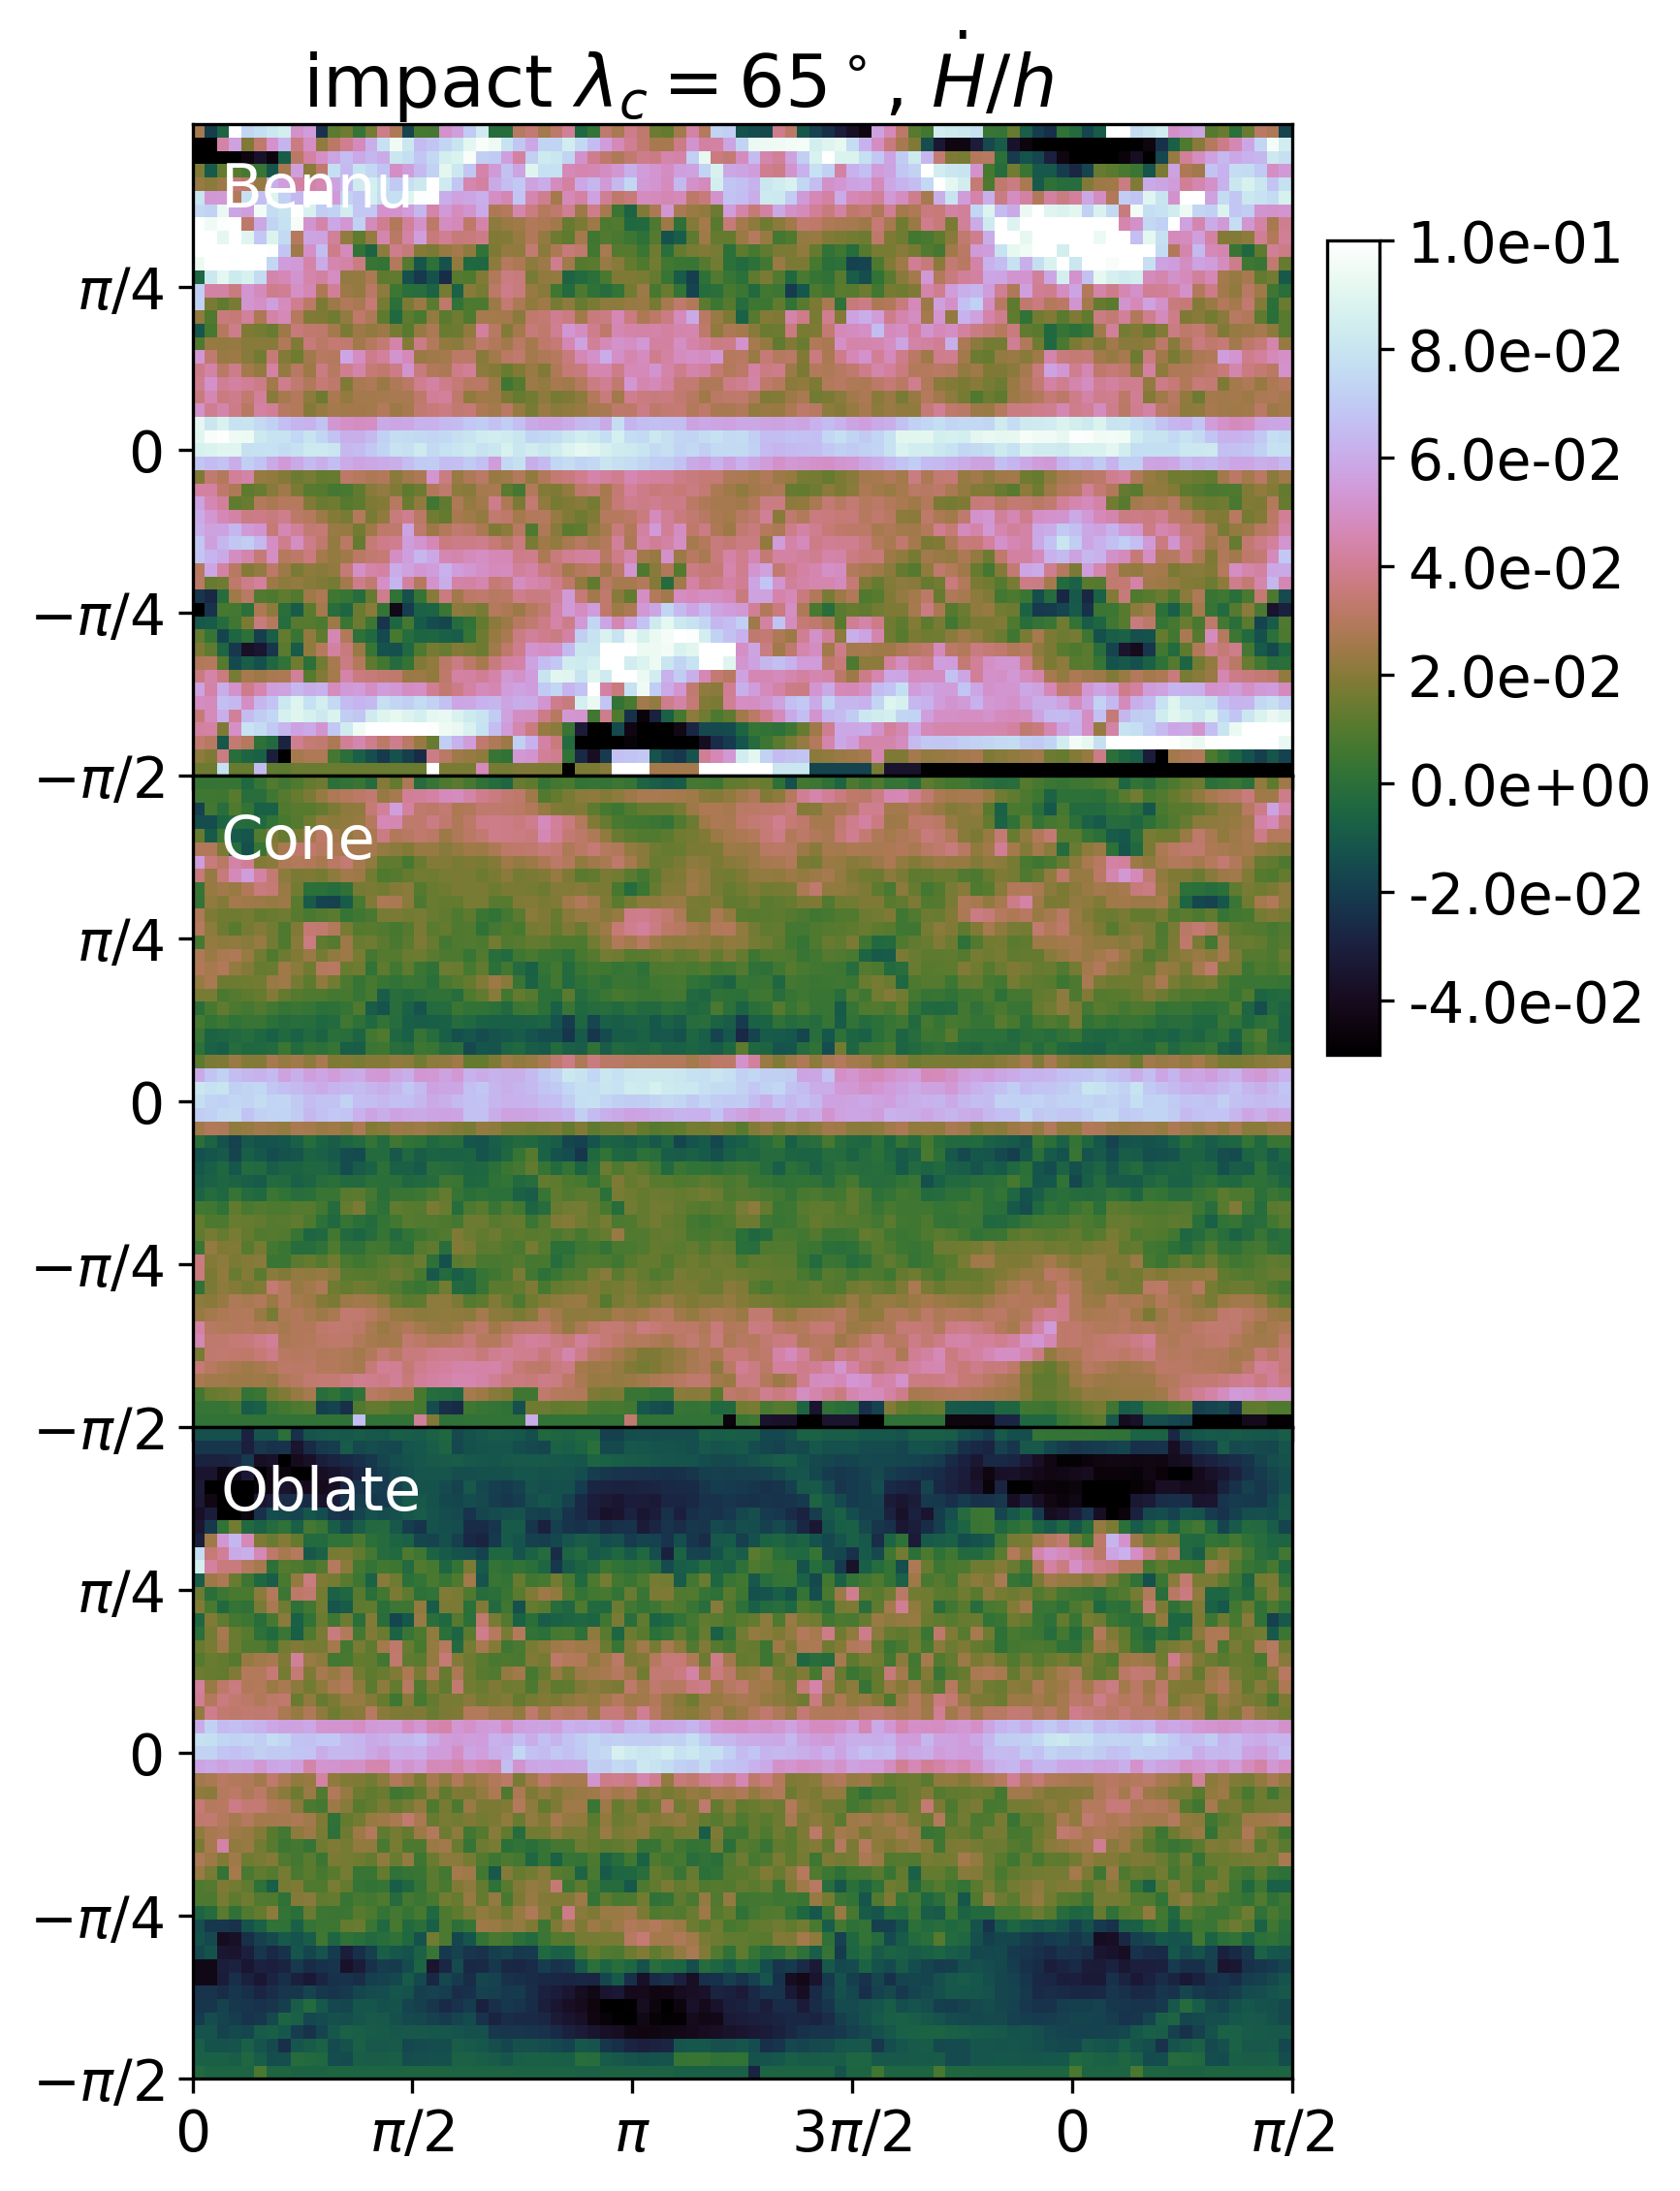

In [92]:
g_betac_fix2 = g_betac1*func(lats_i,0.15)
#g_betab_fix2 = g_betab1*func(lats_i,0.1)
#g_betao_fix2 = g_betao1*func(lats_i,0.1)

g_comboo1_h,grad_s_comboo1_h=combo_consth(g_avev2o1_l,g_ageoo1_l,g_betao_fix,g_sfaco1_l)
g_comboo2_h,grad_s_comboo2_h=combo_consth(g_avev2o2_l,g_ageoo2_l,g_betao_fix,g_sfaco2_l)
g_comboo3_h,grad_s_comboo3_h=combo_consth(g_avev2o3_l,g_ageoo3_l,g_betao_fix,g_sfaco3_l)  
g_comboc1_h,grad_s_comboc1_h=combo_consth(g_avev2c1_l,g_ageoc1_l,g_betac_fix2,g_sfacc1_l) 
g_comboc2_h,grad_s_comboc2_h=combo_consth(g_avev2c2_l,g_ageoc2_l,g_betac_fix2,g_sfacc2_l) 
g_comboc3_h,grad_s_comboc3_h=combo_consth(g_avev2c3_l,g_ageoc3_l,g_betac_fix2,g_sfacc3_l)     
g_combob1_h,grad_s_combob1_h=combo_consth(g_avev2b1_l,g_ageob1_l,g_betab_fix,g_sfacb1_l)     
g_combob2_h,grad_s_combob2_h=combo_consth(g_avev2b2_l,g_ageob2_l,g_betab_fix,g_sfacb2_l)   
g_combob3_h,grad_s_combob3_h=combo_consth(g_avev2b3_l,g_ageob3_l,g_betab_fix,g_sfacb3_l)   

zmax=2e-1; zmin=-0.05
plt3_grided(3*grad_s_combob1_h,grad_s_comboc1_h,grad_s_comboo1_h,label_arr,zmin,zmax,
            toplabel_0 +ch_label,"grad_eq_ch.png")
plt3_grided(3*grad_s_combob2_h,grad_s_comboc2_h,grad_s_comboo2_h,label_arr,zmin,zmax,
            toplabel_15+ch_label,"grad_15_ch.png")
plt3_grided(3*grad_s_combob3_h,grad_s_comboc3_h,grad_s_comboo3_h,label_arr,zmin,0.1,
            toplabel_65+ch_label,"grad_65_ch.png")



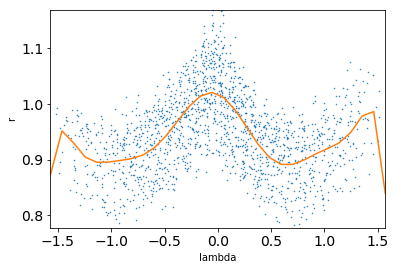

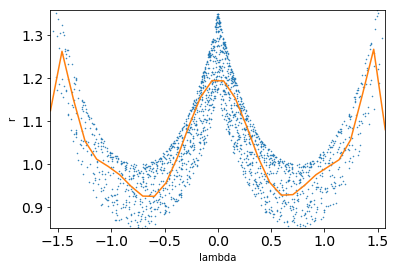

In [47]:
fileroot  = "../bennu2/b1_out/b1_surf"
plt_lambda_funs(fileroot)
fileroot  = "../bennu2/c3_out/c3_surf"
plt_lambda_funs(fileroot)

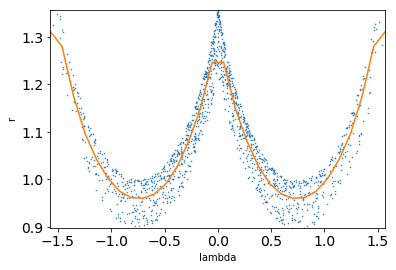

In [53]:
fileroot  = "../bennu2/c3_out/c3_surf"
plt_lambda_funs(fileroot)

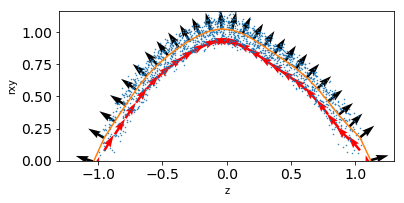

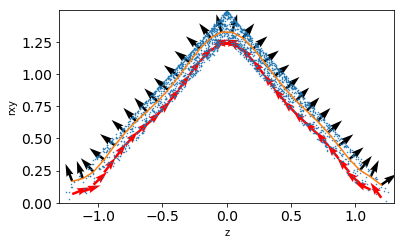

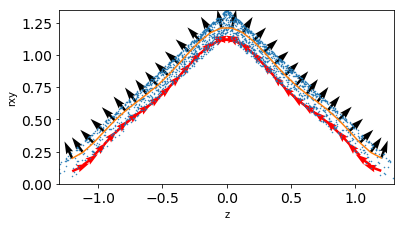

In [252]:
fileroot  = "../bennu2/b1_out/b1_surf"
plt_surfnorm(fileroot)
fileroot  = "../bennu2/c1_out/c1_surf"
plt_surfnorm(fileroot)
fileroot  = "../bennu2/c3_out/c3_surf"
plt_surfnorm(fileroot)

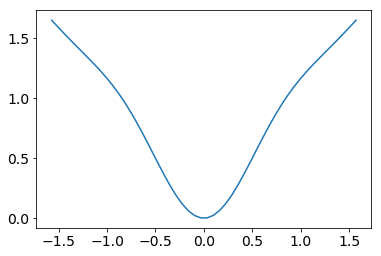

In [272]:
junk = 1-np.cos(lats)  - 1/4.*np.cos(2*lats) - 1/9.*np.cos(3*lats) -1/16.*np.cos(4*lats) - 1/25.*np.cos(5*lats)
x=np.min(junk)
junk = junk-x
plt.plot(lats,junk)

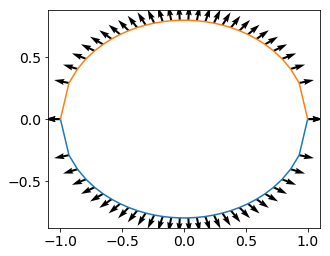

In [303]:
xlin = np.linspace(-1,1,30)
zlin = -0.8*np.sqrt(1.0-xlin*xlin)
nhat_x,nhat_y,nhat_z=nhat_oblate(xlin,0*xlin,zlin)
plt.plot(xlin,zlin,'-')
plt.quiver(xlin,zlin,nhat_x,nhat_z)
ax = plt.gca()
ax.set_aspect('equal')

#xlin = np.linspace(-1,1,30)
zlin = 0.8*np.sqrt(1.0-xlin*xlin)
nhat_x,nhat_y,nhat_z=nhat_oblate(xlin,0*xlin,zlin)
plt.plot(xlin,zlin,'-')
plt.quiver(xlin,zlin,nhat_x,nhat_z)



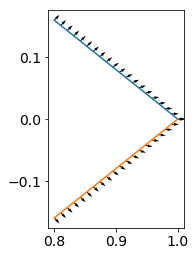

In [319]:
xlin = np.linspace(0.8,1.0,20)
zlin = 0.8*(1-np.abs(xlin))
nhat_x,nhat_y,nhat_z=nhat_cone(xlin,0*xlin,zlin)
plt.plot(xlin,zlin,'-')
plt.quiver(xlin,zlin,nhat_x,nhat_z)
ax = plt.gca()
ax.set_aspect('equal')

#xlin = np.linspace(-1,1,30)
zlin = -0.8*(1-np.abs(xlin))
nhat_x,nhat_y,nhat_z=nhat_cone(xlin,0*xlin,zlin)
plt.plot(xlin,zlin,'-')
plt.quiver(xlin,zlin,nhat_x,nhat_z)